In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from scipy import stats
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
import math

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Normalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

seed = 31102016 
rng = np.random.RandomState(seed)

batch_size = 128

2024-01-07 18:31:45.600660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 18:31:45.640464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 18:31:45.640513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 18:31:45.640540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 18:31:45.647954: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 18:31:45.648434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
filename = "dataset/consolidated_filtered.csv"  # raw consolidated data
dataset = pd.read_csv(filename, index_col='Unnamed: 0')

dataset.head()

timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z  \
0  1697605965  0.011963 -0.855774 -0.029846 -9.625000 -0.859375 -5.656250   
1  1697606005 -0.001709 -0.826233 -0.036194  0.359375  4.953125 -1.656250   
2  1697606045 -0.058838 -0.933899 -0.032532  3.437500  9.406250 -2.031250   
3  1697606085 -0.002441 -1.115051 -0.028870  3.078125  6.921875 -5.984375   
4  1697606125 -0.036621 -1.035217 -0.076477  4.328125  8.125000  0.625000   

  student_number   activity     sub_activity  is_stationary  activity_label  \
0             s1  ascending  breathingNormal              0               0   
1             s1  ascending  breathingNormal              0               0   
2             s1  ascending  breathingNormal              0               0   
3             s1  ascending  breathingNormal              0               0   
4             s1  ascending  breathingNormal              0               0   

   sub_activity_label  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [3]:
def sliding_window(X, label_col, include_gyro=False):
    step = 10
    n = {'activity_label': 12, 'sub_activity_label': 7}
    segments = []
    labels = []

    for i in range(0, len(X)-SLIDING_WINDOW_LENGTH, step):
        xs = X['accel_x'].values[i: i+SLIDING_WINDOW_LENGTH]
        ys = X['accel_y'].values[i: i+SLIDING_WINDOW_LENGTH]
        zs = X['accel_z'].values[i: i+SLIDING_WINDOW_LENGTH]
        
        if include_gyro:
            gx = X['gyro_x'].values[i: i+SLIDING_WINDOW_LENGTH]
            gy = X['gyro_y'].values[i: i+SLIDING_WINDOW_LENGTH]
            gz = X['gyro_z'].values[i: i+SLIDING_WINDOW_LENGTH]

        label = stats.mode(X[label_col][i: i+SLIDING_WINDOW_LENGTH])[0][0]
        label = [0]*label+[1]+[0]*(n[label_col]-label-1)
        if include_gyro:
            segments.append([xs, ys, zs, gx, gy, gz])
        else:
            segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments)
    labels = np.asarray(labels)
    
    X1, X2, y1, y2 = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=rng)
    
    return np.concatenate((X1, X2), axis=0), np.concatenate((y1, y2), axis=0)

# Task 1

In [9]:
SENSOR_CHANNELS = 3
SLIDING_WINDOW_LENGTH = 100

In [5]:
breatheNormalDataset = dataset[dataset.sub_activity == 'breathingNormal']
students = breatheNormalDataset.student_number.unique()

In [10]:
def build_model(xtrn):
    output_dim = 12
    epochs = 100
    dropout_rate = 0.3

    input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

    # LSTM parameters
    n_neurons_lstm = 256
    n_neurons = 64

    # optimization parameters
    lr = 0.001
    decay = 1e-6
    
    normalizer = Normalization()
    normalizer.adapt(xtrn)

    model = Sequential()
    
    model.add(normalizer)

    model.add(Bidirectional(LSTM(units = n_neurons_lstm, activation='relu',
                                 kernel_regularizer=l2(0.0002), bias_regularizer=l2(0.0002)), input_shape=(3,125)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.0002), bias_regularizer=l2(0.0002)))

    model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.0002), bias_regularizer=l2(0.0002)))

    adam = Adam(learning_rate=lr, weight_decay=decay)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    model.summary()
    
    return model

In [7]:
len(students)

71

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dens

Epoch 48/100
374/374 [==============================] - 4s 12ms/step - loss: 0.1611 - accuracy: 0.9576 - val_loss: 0.2223 - val_accuracy: 0.9445
Epoch 49/100
374/374 [==============================] - 4s 12ms/step - loss: 0.1558 - accuracy: 0.9588 - val_loss: 0.2172 - val_accuracy: 0.9474
Epoch 50/100
374/374 [==============================] - 4s 12ms/step - loss: 0.1594 - accuracy: 0.9576 - val_loss: 0.2298 - val_accuracy: 0.9397
Epoch 51/100
374/374 [==============================] - 4s 12ms/step - loss: 0.1534 - accuracy: 0.9598 - val_loss: 0.2272 - val_accuracy: 0.9467
Epoch 52/100
374/374 [==============================] - 4s 11ms/step - loss: 0.1652 - accuracy: 0.9555 - val_loss: 0.2571 - val_accuracy: 0.9334
Epoch 53/100
374/374 [==============================] - 4s 12ms/step - loss: 0.1612 - accuracy: 0.9573 - val_loss: 0.2273 - val_accuracy: 0.9388
Epoch 54/100
374/374 [==============================] - 4s 12ms/step - loss: 0.1532 - accuracy: 0.9599 - val_loss: 0.2366 - val_ac

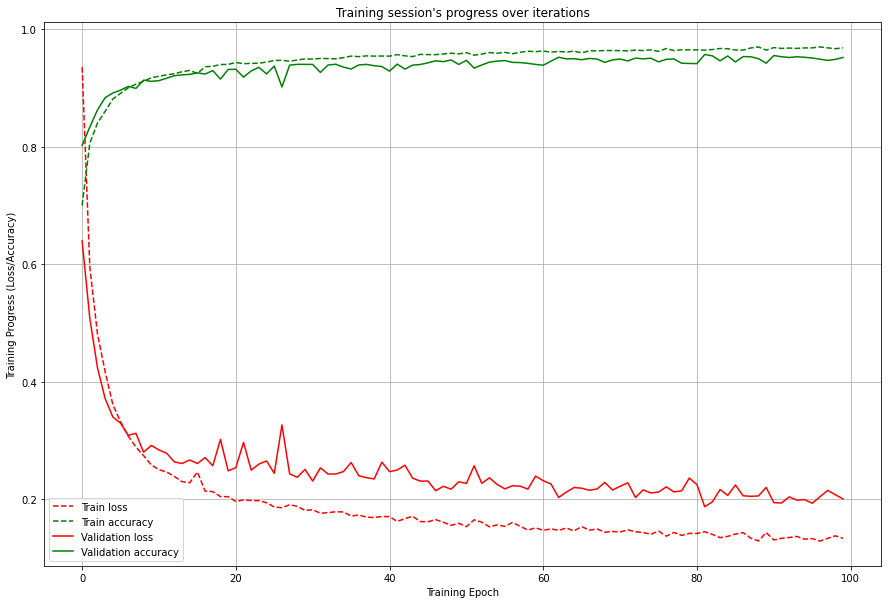

 ..after sliding and reshaping, train data: inputs (59887, 3, 100), targets (59887, 12)
 ..after sliding and reshaping, test data : inputs (812, 3, 100), targets (812, 12)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dens

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1579 - accuracy: 0.9587 - val_loss: 0.2025 - val_accuracy: 0.9511
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1553 - accuracy: 0.9589 - val_loss: 0.2111 - val_accuracy: 0.9461
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1550 - accuracy: 0.9593 - val_loss: 0.2266 - val_accuracy: 0.9457
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1631 - accuracy: 0.9568 - val_loss: 0.2355 - val_accuracy: 0.9362
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1609 - accuracy: 0.9569 - val_loss: 0.2211 - val_accuracy: 0.9469
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1570 - accuracy: 0.9590 - val_loss: 0.2198 - val_accuracy: 0.9448
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1515 - accuracy: 0.9610 - val_loss: 0.1978 - val_ac

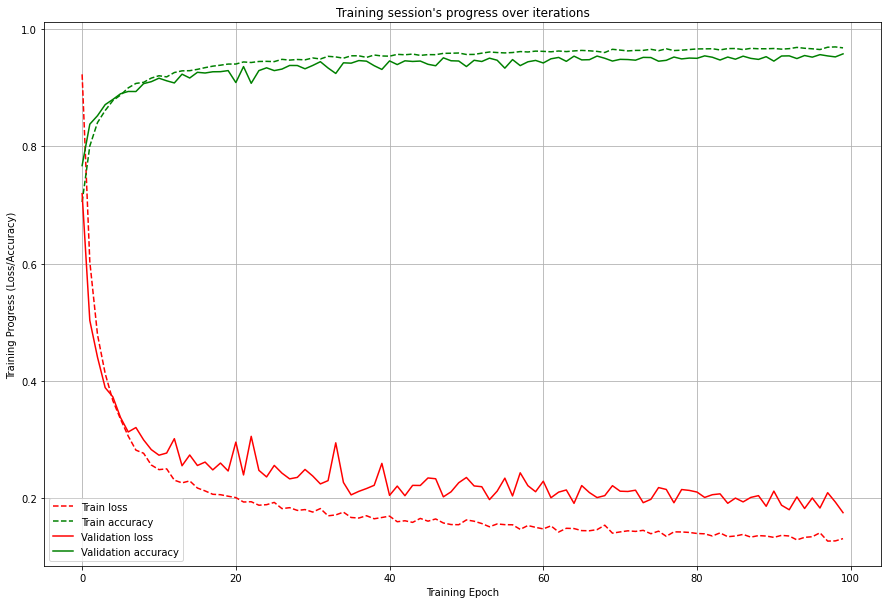

 ..after sliding and reshaping, train data: inputs (59943, 3, 100), targets (59943, 12)
 ..after sliding and reshaping, test data : inputs (755, 3, 100), targets (755, 12)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Den

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1638 - accuracy: 0.9571 - val_loss: 0.2080 - val_accuracy: 0.9515
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1651 - accuracy: 0.9552 - val_loss: 0.2132 - val_accuracy: 0.9480
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9584 - val_loss: 0.2271 - val_accuracy: 0.9449
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1579 - accuracy: 0.9586 - val_loss: 0.2313 - val_accuracy: 0.9417
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1626 - accuracy: 0.9567 - val_loss: 0.2284 - val_accuracy: 0.9432
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1593 - accuracy: 0.9586 - val_loss: 0.2195 - val_accuracy: 0.9492
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1613 - accuracy: 0.9579 - val_loss: 0.2260 - val_ac

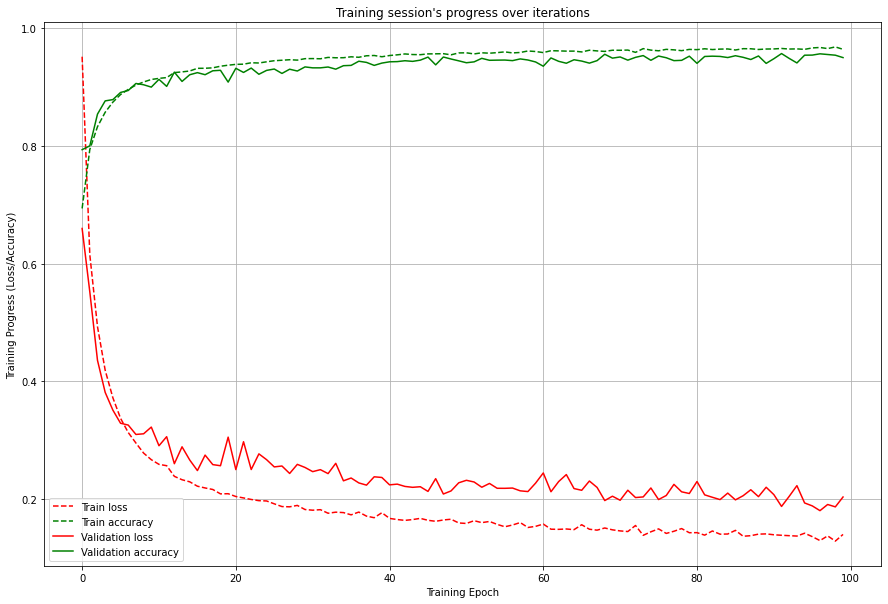

 ..after sliding and reshaping, train data: inputs (59808, 3, 100), targets (59808, 12)
 ..after sliding and reshaping, test data : inputs (890, 3, 100), targets (890, 12)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Den

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1575 - accuracy: 0.9598 - val_loss: 0.2236 - val_accuracy: 0.9441
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1501 - accuracy: 0.9624 - val_loss: 0.2286 - val_accuracy: 0.9434
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9606 - val_loss: 0.2278 - val_accuracy: 0.9435
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1491 - accuracy: 0.9633 - val_loss: 0.2323 - val_accuracy: 0.9417
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1522 - accuracy: 0.9619 - val_loss: 0.2296 - val_accuracy: 0.9378
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1561 - accuracy: 0.9604 - val_loss: 0.2257 - val_accuracy: 0.9449
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1488 - accuracy: 0.9630 - val_loss: 0.2255 - val_ac

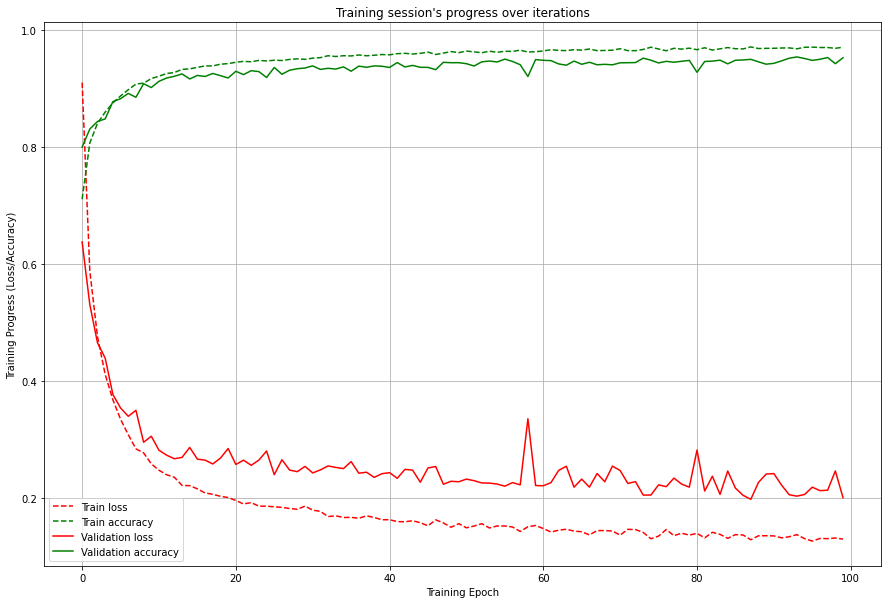

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 dense_15 (Den

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1544 - accuracy: 0.9605 - val_loss: 0.2506 - val_accuracy: 0.9384
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1524 - accuracy: 0.9601 - val_loss: 0.2365 - val_accuracy: 0.9429
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1542 - accuracy: 0.9595 - val_loss: 0.2632 - val_accuracy: 0.9370
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1651 - accuracy: 0.9575 - val_loss: 0.2279 - val_accuracy: 0.9435
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1599 - accuracy: 0.9581 - val_loss: 0.2330 - val_accuracy: 0.9446
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1566 - accuracy: 0.9598 - val_loss: 0.2251 - val_accuracy: 0.9440
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9602 - val_loss: 0.2266 - val_ac

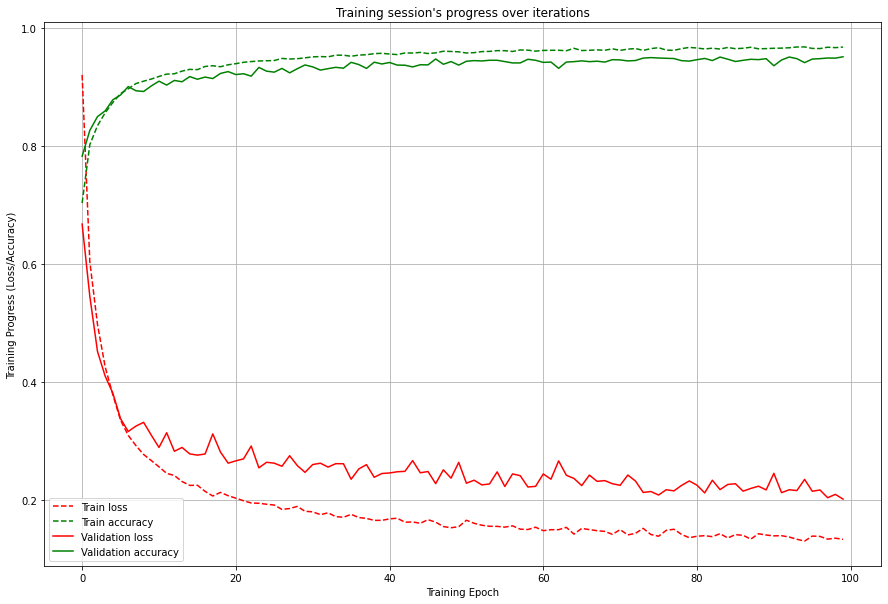

 ..after sliding and reshaping, train data: inputs (59868, 3, 100), targets (59868, 12)
 ..after sliding and reshaping, test data : inputs (831, 3, 100), targets (831, 12)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                32832     
                                                                 
 dense_17 (Den

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1655 - accuracy: 0.9552 - val_loss: 0.2456 - val_accuracy: 0.9400
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9581 - val_loss: 0.2368 - val_accuracy: 0.9383
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1526 - accuracy: 0.9596 - val_loss: 0.2508 - val_accuracy: 0.9361
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1599 - accuracy: 0.9574 - val_loss: 0.2411 - val_accuracy: 0.9431
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1524 - accuracy: 0.9597 - val_loss: 0.2202 - val_accuracy: 0.9420
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1551 - accuracy: 0.9596 - val_loss: 0.2444 - val_accuracy: 0.9405
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1488 - accuracy: 0.9617 - val_loss: 0.2381 - val_ac

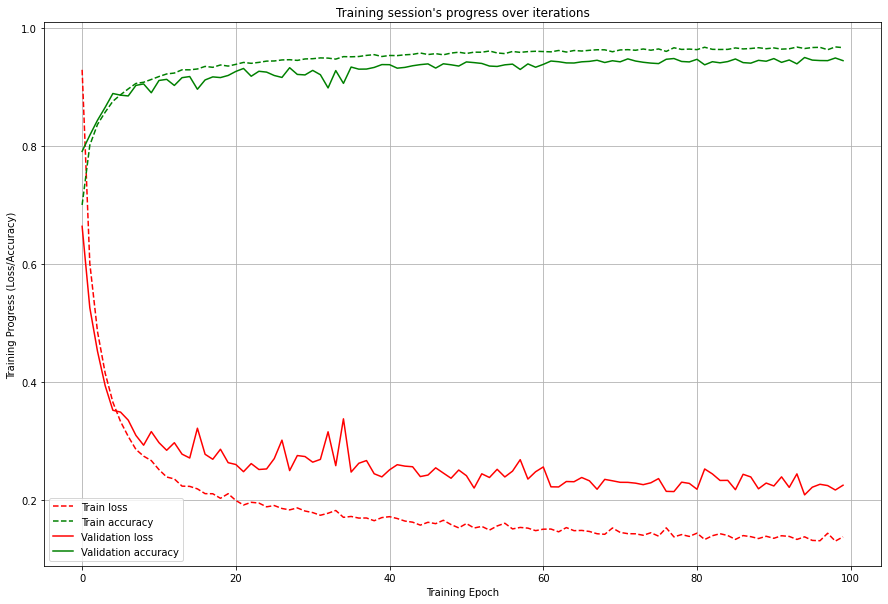

 ..after sliding and reshaping, train data: inputs (59804, 3, 100), targets (59804, 12)
 ..after sliding and reshaping, test data : inputs (894, 3, 100), targets (894, 12)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normaliza  (None, None, 100)         201       
 tion)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                32832     
                                                                 
 dense_19 (Den

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1599 - accuracy: 0.9561 - val_loss: 0.2258 - val_accuracy: 0.9483
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1569 - accuracy: 0.9580 - val_loss: 0.2256 - val_accuracy: 0.9435
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1556 - accuracy: 0.9591 - val_loss: 0.2152 - val_accuracy: 0.9467
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1589 - accuracy: 0.9569 - val_loss: 0.2340 - val_accuracy: 0.9432
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1578 - accuracy: 0.9582 - val_loss: 0.2628 - val_accuracy: 0.9335
Epoch 53/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1562 - accuracy: 0.9593 - val_loss: 0.2136 - val_accuracy: 0.9408
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1553 - accuracy: 0.9591 - val_loss: 0.2116 - val_ac

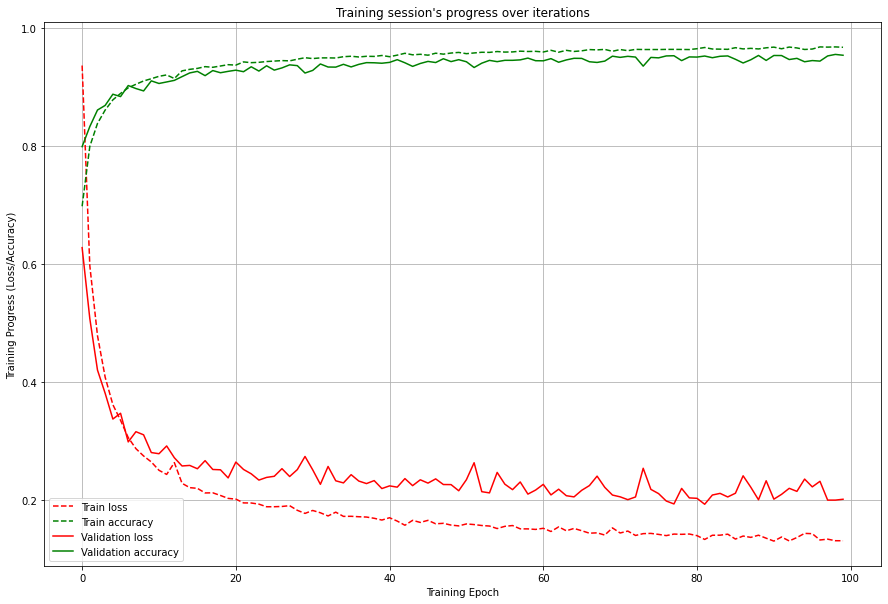

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_10 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                32832     
                                                                 
 dense_21 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1605 - accuracy: 0.9579 - val_loss: 0.2428 - val_accuracy: 0.9344
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1599 - accuracy: 0.9573 - val_loss: 0.2369 - val_accuracy: 0.9400
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1594 - accuracy: 0.9574 - val_loss: 0.2268 - val_accuracy: 0.9428
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1612 - accuracy: 0.9580 - val_loss: 0.2273 - val_accuracy: 0.9427
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1600 - accuracy: 0.9585 - val_loss: 0.2235 - val_accuracy: 0.9447
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1530 - accuracy: 0.9606 - val_loss: 0.2121 - val_accuracy: 0.9468
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9590 - val_loss: 0.2257 - val_ac

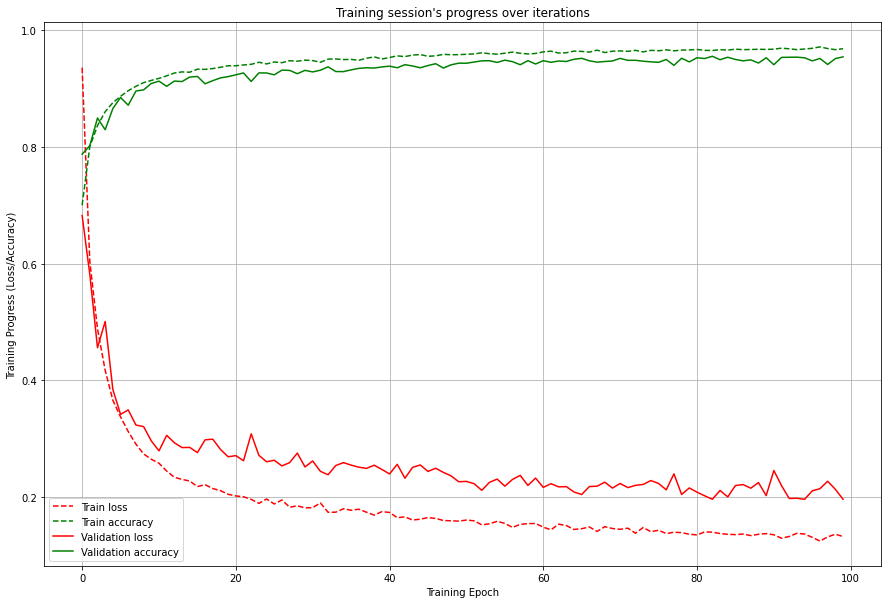

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                32832     
                                                                 
 dense_23 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9586 - val_loss: 0.2543 - val_accuracy: 0.9375
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1537 - accuracy: 0.9604 - val_loss: 0.2378 - val_accuracy: 0.9411
Epoch 50/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1520 - accuracy: 0.9596 - val_loss: 0.2308 - val_accuracy: 0.9395
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9586 - val_loss: 0.2276 - val_accuracy: 0.9415
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1529 - accuracy: 0.9601 - val_loss: 0.2481 - val_accuracy: 0.9415
Epoch 53/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1507 - accuracy: 0.9610 - val_loss: 0.2388 - val_accuracy: 0.9455
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1533 - accuracy: 0.9595 - val_loss: 0.2317 - val_ac

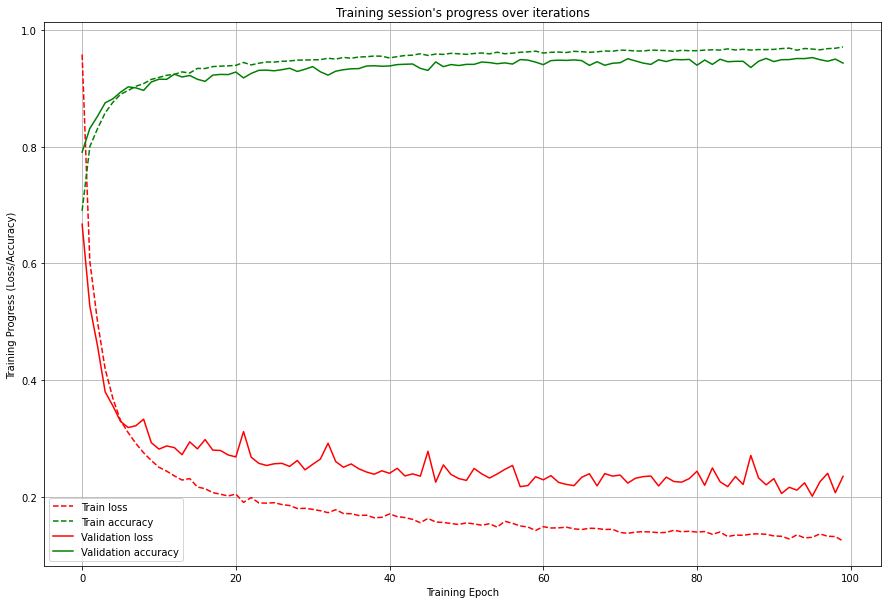

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_12 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                32832     
                                                                 
 dense_25 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9574 - val_loss: 0.2406 - val_accuracy: 0.9389
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1518 - accuracy: 0.9601 - val_loss: 0.2499 - val_accuracy: 0.9350
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1558 - accuracy: 0.9585 - val_loss: 0.2262 - val_accuracy: 0.9411
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1550 - accuracy: 0.9589 - val_loss: 0.2585 - val_accuracy: 0.9360
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1627 - accuracy: 0.9573 - val_loss: 0.2304 - val_accuracy: 0.9365
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1539 - accuracy: 0.9604 - val_loss: 0.2209 - val_accuracy: 0.9462
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1500 - accuracy: 0.9611 - val_loss: 0.2284 - val_ac

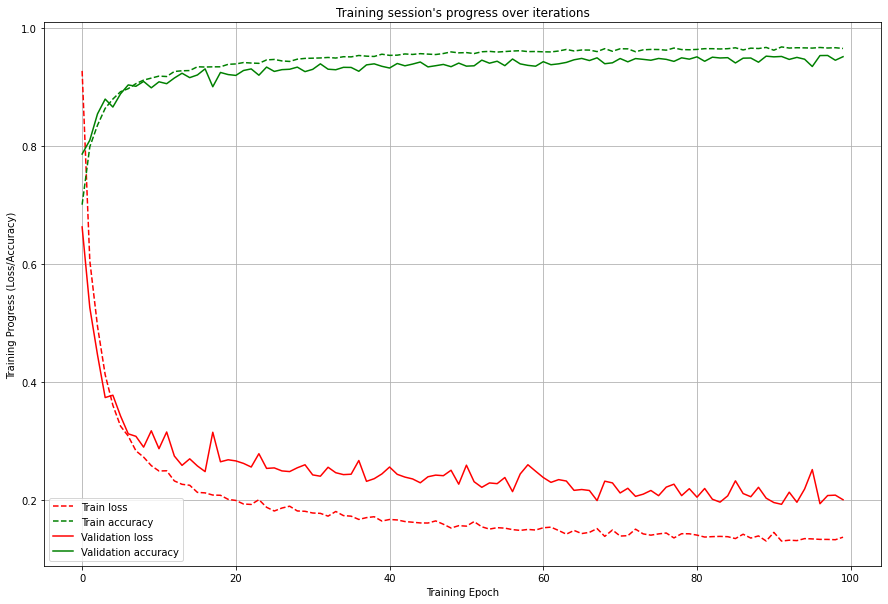

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                32832     
                                                                 
 dense_27 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1645 - accuracy: 0.9569 - val_loss: 0.2783 - val_accuracy: 0.9229
Epoch 49/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1641 - accuracy: 0.9575 - val_loss: 0.2497 - val_accuracy: 0.9361
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1553 - accuracy: 0.9599 - val_loss: 0.2453 - val_accuracy: 0.9401
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9590 - val_loss: 0.2382 - val_accuracy: 0.9409
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1558 - accuracy: 0.9604 - val_loss: 0.2256 - val_accuracy: 0.9404
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9598 - val_loss: 0.2224 - val_accuracy: 0.9452
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1551 - accuracy: 0.9602 - val_loss: 0.2445 - val_ac

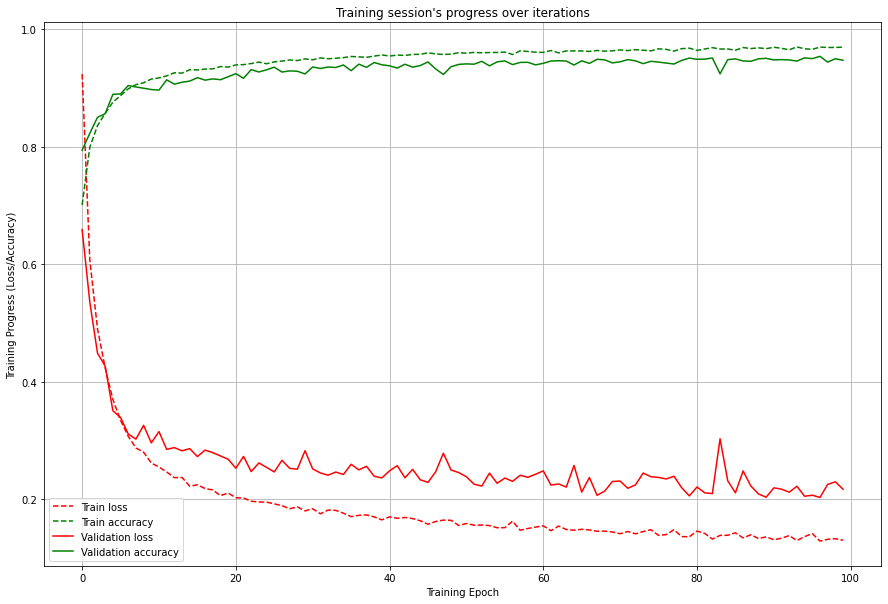

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_14 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                32832     
                                                                 
 dense_29 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1586 - accuracy: 0.9571 - val_loss: 0.2470 - val_accuracy: 0.9343
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1585 - accuracy: 0.9579 - val_loss: 0.2213 - val_accuracy: 0.9454
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1575 - accuracy: 0.9578 - val_loss: 0.2222 - val_accuracy: 0.9448
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1511 - accuracy: 0.9602 - val_loss: 0.2246 - val_accuracy: 0.9398
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1594 - accuracy: 0.9581 - val_loss: 0.2371 - val_accuracy: 0.9389
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1571 - accuracy: 0.9585 - val_loss: 0.2166 - val_accuracy: 0.9427
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1537 - accuracy: 0.9602 - val_loss: 0.2444 - val_ac

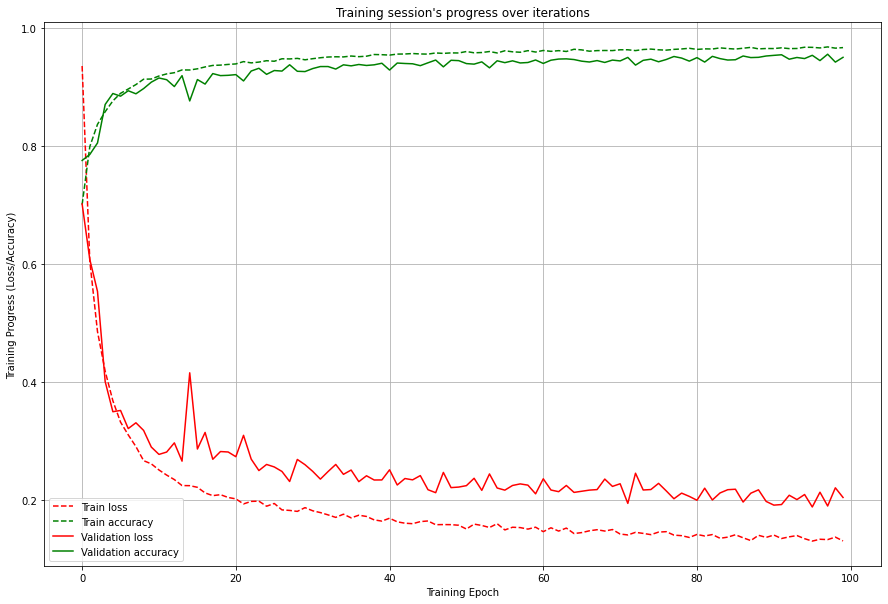

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                32832     
                                                                 
 dense_31 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1581 - accuracy: 0.9585 - val_loss: 0.2302 - val_accuracy: 0.9440
Epoch 49/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1565 - accuracy: 0.9587 - val_loss: 0.2361 - val_accuracy: 0.9389
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1574 - accuracy: 0.9588 - val_loss: 0.2824 - val_accuracy: 0.9269
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1531 - accuracy: 0.9593 - val_loss: 0.2167 - val_accuracy: 0.9436
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1498 - accuracy: 0.9608 - val_loss: 0.2274 - val_accuracy: 0.9419
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1487 - accuracy: 0.9619 - val_loss: 0.2107 - val_accuracy: 0.9454
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1552 - accuracy: 0.9586 - val_loss: 0.2275 - val_ac

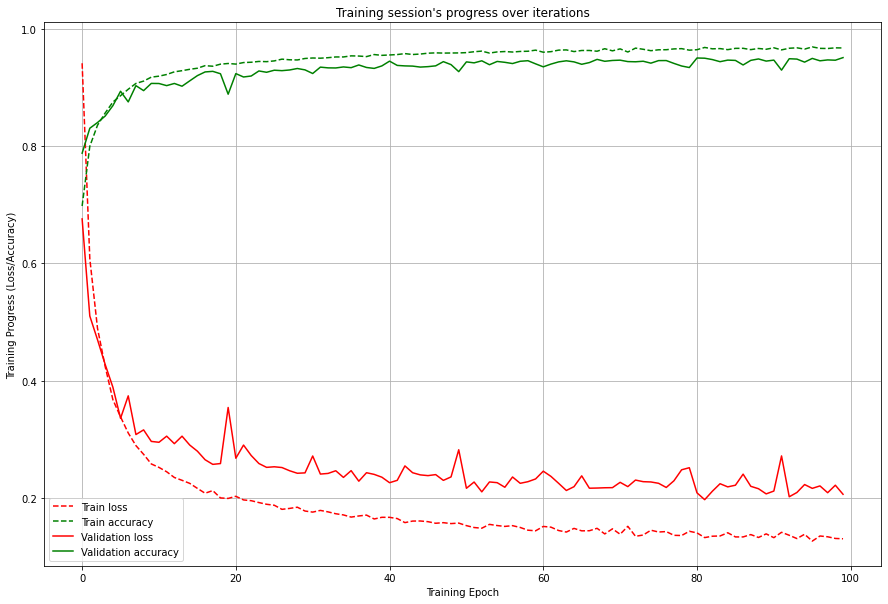

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_16 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                32832     
                                                                 
 dense_33 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1611 - accuracy: 0.9576 - val_loss: 0.2128 - val_accuracy: 0.9473
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1629 - accuracy: 0.9559 - val_loss: 0.2211 - val_accuracy: 0.9448
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1541 - accuracy: 0.9586 - val_loss: 0.2309 - val_accuracy: 0.9461
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1580 - accuracy: 0.9583 - val_loss: 0.2225 - val_accuracy: 0.9463
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1651 - accuracy: 0.9551 - val_loss: 0.2239 - val_accuracy: 0.9472
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1558 - accuracy: 0.9585 - val_loss: 0.2303 - val_accuracy: 0.9447
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1533 - accuracy: 0.9603 - val_loss: 0.2262 - val_ac

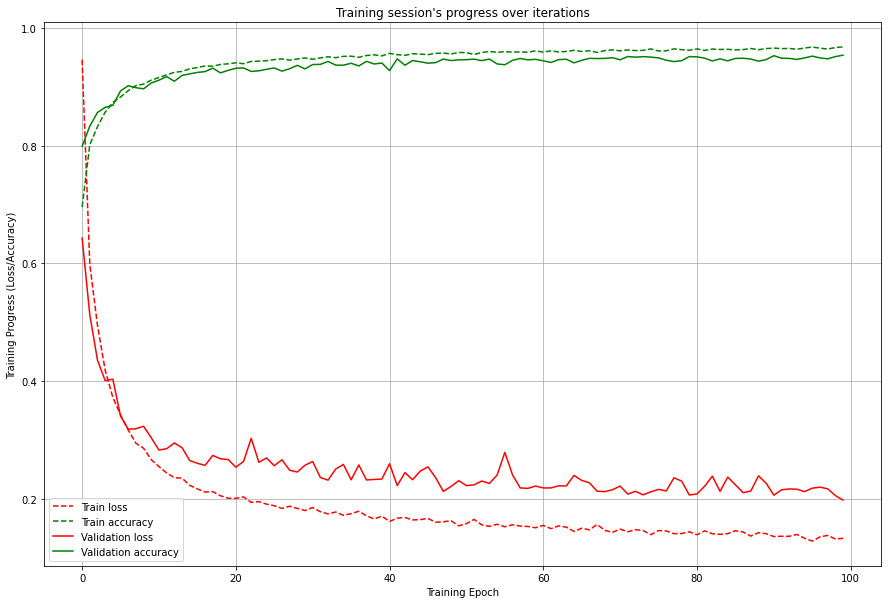

 ..after sliding and reshaping, train data: inputs (59948, 3, 100), targets (59948, 12)
 ..after sliding and reshaping, test data : inputs (750, 3, 100), targets (750, 12)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_17 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                32832     
                                                                 
 dense_35 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1589 - accuracy: 0.9577 - val_loss: 0.2156 - val_accuracy: 0.9449
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1624 - accuracy: 0.9568 - val_loss: 0.2376 - val_accuracy: 0.9423
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1594 - accuracy: 0.9580 - val_loss: 0.2249 - val_accuracy: 0.9422
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1563 - accuracy: 0.9598 - val_loss: 0.2241 - val_accuracy: 0.9381
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1546 - accuracy: 0.9592 - val_loss: 0.2143 - val_accuracy: 0.9454
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1583 - accuracy: 0.9585 - val_loss: 0.2291 - val_accuracy: 0.9422
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1510 - accuracy: 0.9611 - val_loss: 0.2239 - val_ac

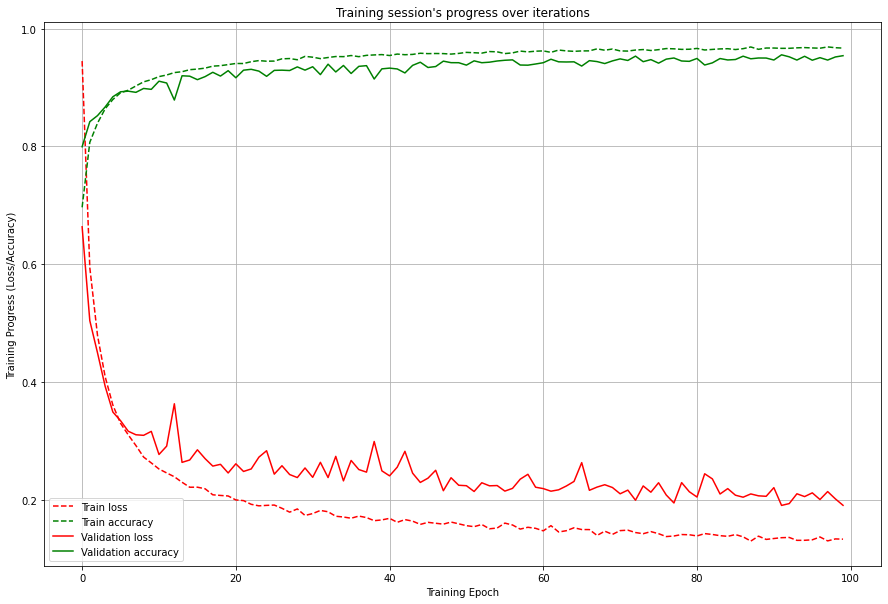

 ..after sliding and reshaping, train data: inputs (59797, 3, 100), targets (59797, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_18 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_18 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                32832     
                                                                 
 dense_37 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1530 - accuracy: 0.9592 - val_loss: 0.2777 - val_accuracy: 0.9248
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1535 - accuracy: 0.9598 - val_loss: 0.2296 - val_accuracy: 0.9423
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1578 - accuracy: 0.9582 - val_loss: 0.2262 - val_accuracy: 0.9419
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1539 - accuracy: 0.9597 - val_loss: 0.2441 - val_accuracy: 0.9400
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1613 - accuracy: 0.9577 - val_loss: 0.2238 - val_accuracy: 0.9407
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1528 - accuracy: 0.9599 - val_loss: 0.2046 - val_accuracy: 0.9488
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1521 - accuracy: 0.9606 - val_loss: 0.2169 - val_ac

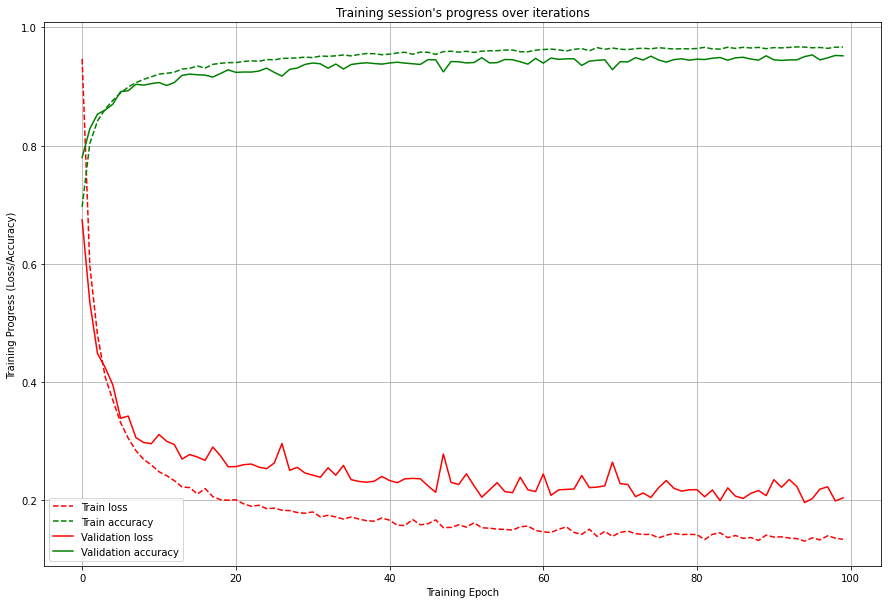

 ..after sliding and reshaping, train data: inputs (59802, 3, 100), targets (59802, 12)
 ..after sliding and reshaping, test data : inputs (897, 3, 100), targets (897, 12)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_19 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_19 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 64)                32832     
                                                                 
 dense_39 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1539 - accuracy: 0.9612 - val_loss: 0.2214 - val_accuracy: 0.9431
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1649 - accuracy: 0.9573 - val_loss: 0.2216 - val_accuracy: 0.9457
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1506 - accuracy: 0.9621 - val_loss: 0.2089 - val_accuracy: 0.9489
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9596 - val_loss: 0.2365 - val_accuracy: 0.9411
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1515 - accuracy: 0.9613 - val_loss: 0.2058 - val_accuracy: 0.9502
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1530 - accuracy: 0.9603 - val_loss: 0.2194 - val_accuracy: 0.9473
Epoch 54/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1547 - accuracy: 0.9602 - val_loss: 0.2251 - val_ac

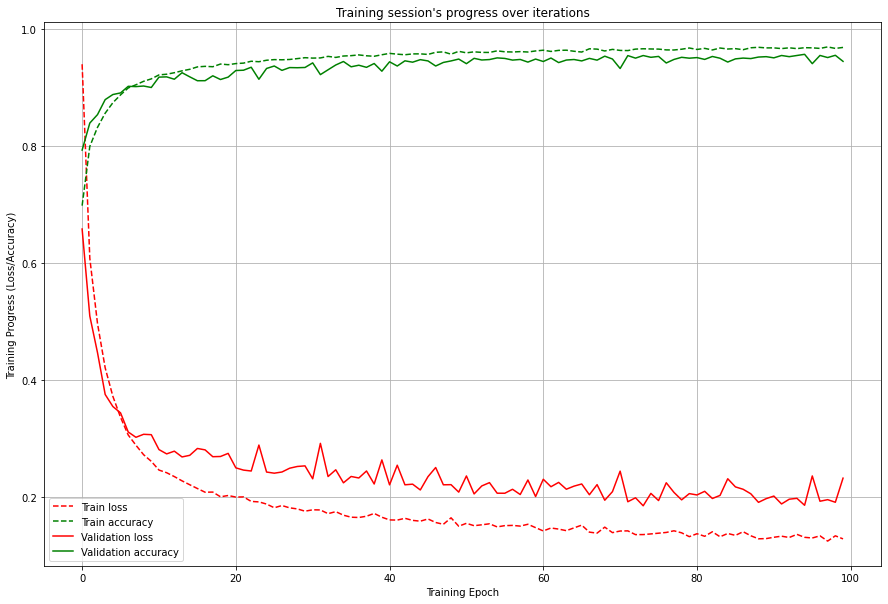

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_20 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_20 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                32832     
                                                                 
 dense_41 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1553 - accuracy: 0.9592 - val_loss: 0.2296 - val_accuracy: 0.9362
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1588 - accuracy: 0.9581 - val_loss: 0.2394 - val_accuracy: 0.9372
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1642 - accuracy: 0.9553 - val_loss: 0.2372 - val_accuracy: 0.9366
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1637 - accuracy: 0.9569 - val_loss: 0.2517 - val_accuracy: 0.9252
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1603 - accuracy: 0.9576 - val_loss: 0.2130 - val_accuracy: 0.9436
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1540 - accuracy: 0.9594 - val_loss: 0.2281 - val_accuracy: 0.9379
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1628 - accuracy: 0.9568 - val_loss: 0.2450 - val_ac

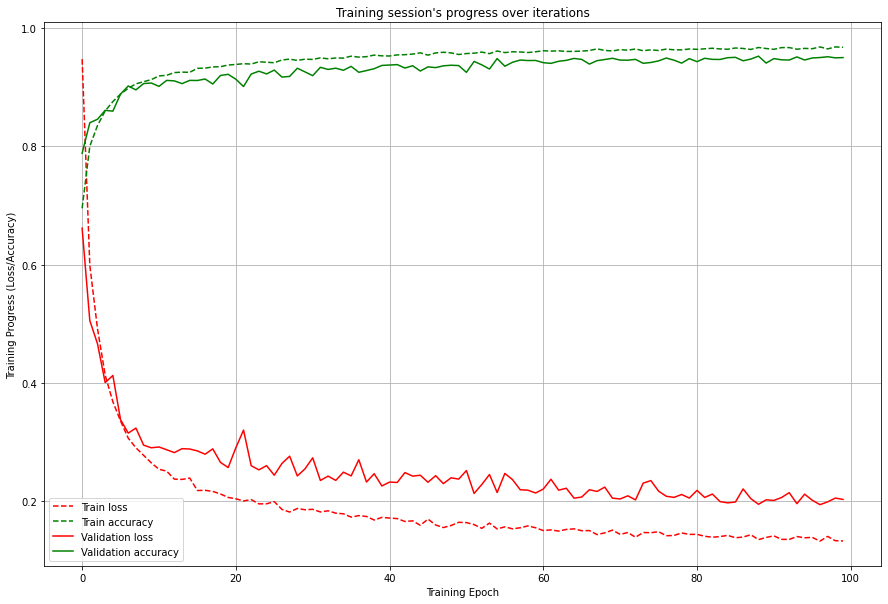

 ..after sliding and reshaping, train data: inputs (59806, 3, 100), targets (59806, 12)
 ..after sliding and reshaping, test data : inputs (893, 3, 100), targets (893, 12)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_21 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_21 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                32832     
                                                                 
 dense_43 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1610 - accuracy: 0.9584 - val_loss: 0.2701 - val_accuracy: 0.9339
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1605 - accuracy: 0.9583 - val_loss: 0.2401 - val_accuracy: 0.9395
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1648 - accuracy: 0.9556 - val_loss: 0.2596 - val_accuracy: 0.9333
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1564 - accuracy: 0.9595 - val_loss: 0.2409 - val_accuracy: 0.9395
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1583 - accuracy: 0.9586 - val_loss: 0.2494 - val_accuracy: 0.9367
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1511 - accuracy: 0.9611 - val_loss: 0.2400 - val_accuracy: 0.9412
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1556 - accuracy: 0.9600 - val_loss: 0.2332 - val_ac

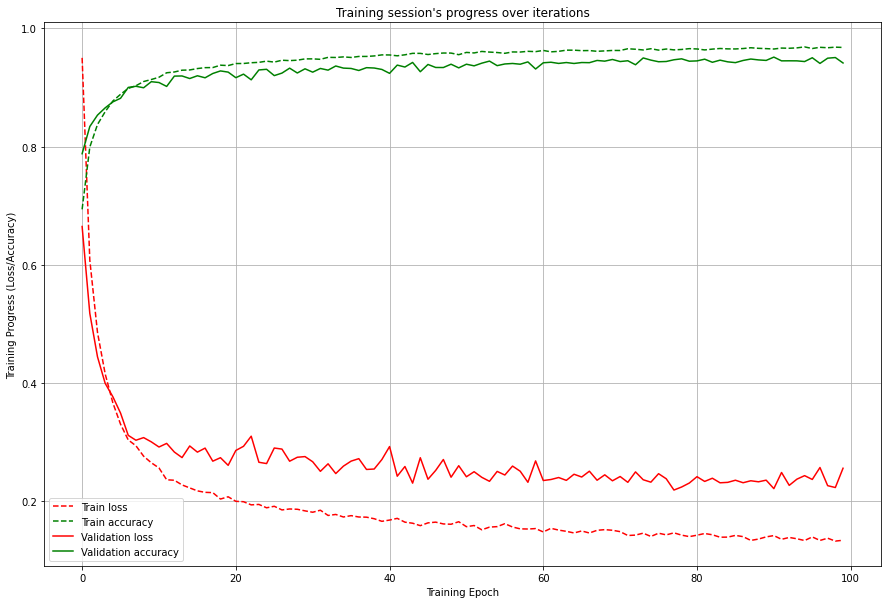

 ..after sliding and reshaping, train data: inputs (59883, 3, 100), targets (59883, 12)
 ..after sliding and reshaping, test data : inputs (816, 3, 100), targets (816, 12)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_22 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_22 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 64)                32832     
                                                                 
 dense_45 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1574 - accuracy: 0.9576 - val_loss: 0.2318 - val_accuracy: 0.9399
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1625 - accuracy: 0.9544 - val_loss: 0.2520 - val_accuracy: 0.9312
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1566 - accuracy: 0.9581 - val_loss: 0.2239 - val_accuracy: 0.9451
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1606 - accuracy: 0.9571 - val_loss: 0.2590 - val_accuracy: 0.9336
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1579 - accuracy: 0.9585 - val_loss: 0.2345 - val_accuracy: 0.9417
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9584 - val_loss: 0.2332 - val_accuracy: 0.9411
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1572 - accuracy: 0.9576 - val_loss: 0.2252 - val_ac

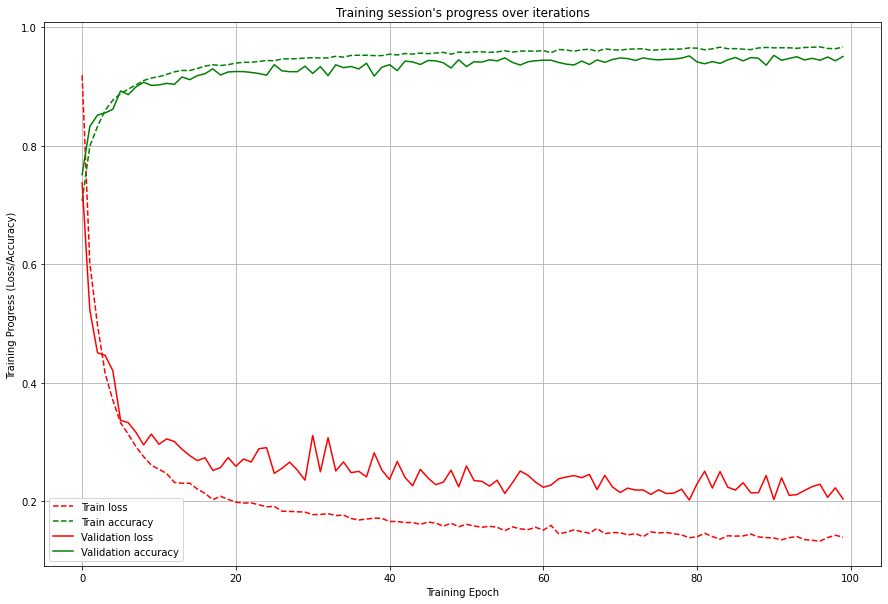

 ..after sliding and reshaping, train data: inputs (59808, 3, 100), targets (59808, 12)
 ..after sliding and reshaping, test data : inputs (891, 3, 100), targets (891, 12)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_23 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_23 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_46 (Dense)            (None, 64)                32832     
                                                                 
 dense_47 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1602 - accuracy: 0.9594 - val_loss: 0.2309 - val_accuracy: 0.9409
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9602 - val_loss: 0.2226 - val_accuracy: 0.9456
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1566 - accuracy: 0.9585 - val_loss: 0.2332 - val_accuracy: 0.9427
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1496 - accuracy: 0.9619 - val_loss: 0.2553 - val_accuracy: 0.9364
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1554 - accuracy: 0.9599 - val_loss: 0.2598 - val_accuracy: 0.9411
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9604 - val_loss: 0.2668 - val_accuracy: 0.9370
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9607 - val_loss: 0.2438 - val_ac

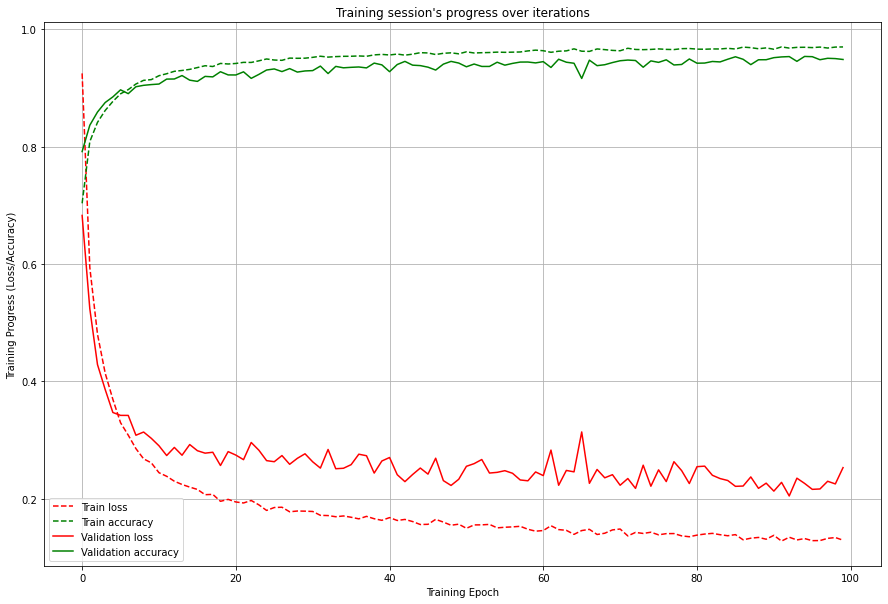

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_24 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_48 (Dense)            (None, 64)                32832     
                                                                 
 dense_49 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1623 - accuracy: 0.9557 - val_loss: 0.2228 - val_accuracy: 0.9396
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1538 - accuracy: 0.9578 - val_loss: 0.2213 - val_accuracy: 0.9424
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1628 - accuracy: 0.9550 - val_loss: 0.2354 - val_accuracy: 0.9412
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1546 - accuracy: 0.9589 - val_loss: 0.2316 - val_accuracy: 0.9445
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1638 - accuracy: 0.9552 - val_loss: 0.2186 - val_accuracy: 0.9474
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1567 - accuracy: 0.9578 - val_loss: 0.2388 - val_accuracy: 0.9397
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9579 - val_loss: 0.2187 - val_ac

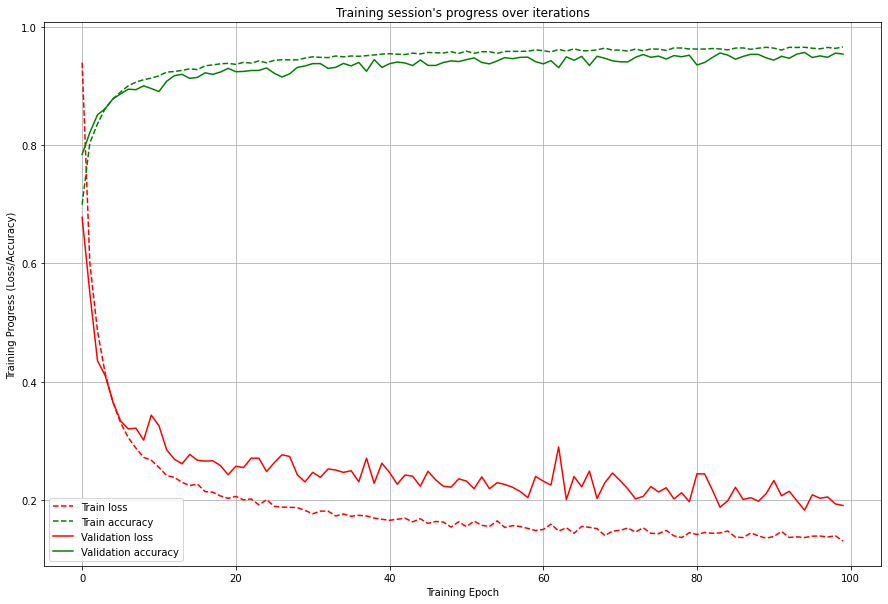

 ..after sliding and reshaping, train data: inputs (59798, 3, 100), targets (59798, 12)
 ..after sliding and reshaping, test data : inputs (900, 3, 100), targets (900, 12)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_25 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 64)                32832     
                                                                 
 dense_51 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1610 - accuracy: 0.9575 - val_loss: 0.2170 - val_accuracy: 0.9421
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1594 - accuracy: 0.9575 - val_loss: 0.2235 - val_accuracy: 0.9410
Epoch 50/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1606 - accuracy: 0.9578 - val_loss: 0.2195 - val_accuracy: 0.9492
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9590 - val_loss: 0.2241 - val_accuracy: 0.9438
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1517 - accuracy: 0.9597 - val_loss: 0.2142 - val_accuracy: 0.9511
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1488 - accuracy: 0.9615 - val_loss: 0.2162 - val_accuracy: 0.9453
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9596 - val_loss: 0.2244 - val_ac

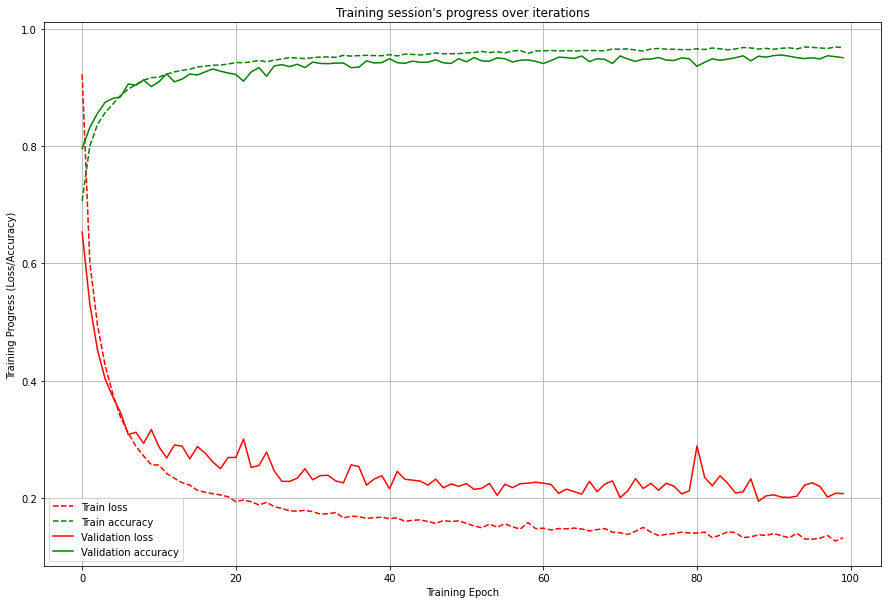

 ..after sliding and reshaping, train data: inputs (59883, 3, 100), targets (59883, 12)
 ..after sliding and reshaping, test data : inputs (815, 3, 100), targets (815, 12)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_26 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_26 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                32832     
                                                                 
 dense_53 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1527 - accuracy: 0.9626 - val_loss: 0.2208 - val_accuracy: 0.9473
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1572 - accuracy: 0.9603 - val_loss: 0.2489 - val_accuracy: 0.9407
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1548 - accuracy: 0.9610 - val_loss: 0.2596 - val_accuracy: 0.9379
Epoch 51/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1585 - accuracy: 0.9591 - val_loss: 0.2501 - val_accuracy: 0.9426
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1524 - accuracy: 0.9622 - val_loss: 0.2382 - val_accuracy: 0.9443
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1637 - accuracy: 0.9570 - val_loss: 0.2331 - val_accuracy: 0.9455
Epoch 54/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1450 - accuracy: 0.9643 - val_loss: 0.2431 - val_ac

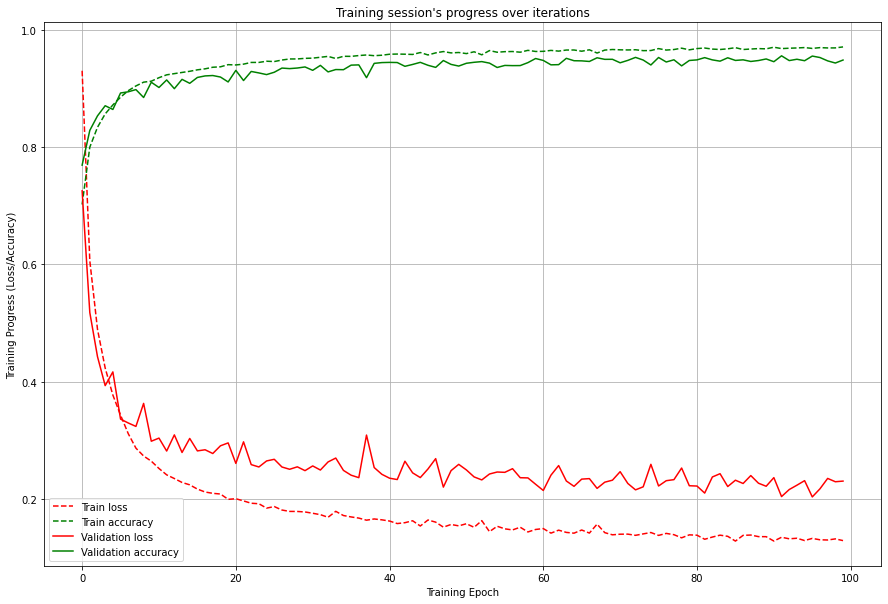

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_27 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_54 (Dense)            (None, 64)                32832     
                                                                 
 dense_55 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1621 - accuracy: 0.9560 - val_loss: 0.2383 - val_accuracy: 0.9413
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1581 - accuracy: 0.9573 - val_loss: 0.2305 - val_accuracy: 0.9381
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1584 - accuracy: 0.9571 - val_loss: 0.2191 - val_accuracy: 0.9447
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1533 - accuracy: 0.9589 - val_loss: 0.2123 - val_accuracy: 0.9467
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9581 - val_loss: 0.2198 - val_accuracy: 0.9395
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9590 - val_loss: 0.2737 - val_accuracy: 0.9299
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1570 - accuracy: 0.9588 - val_loss: 0.2195 - val_ac

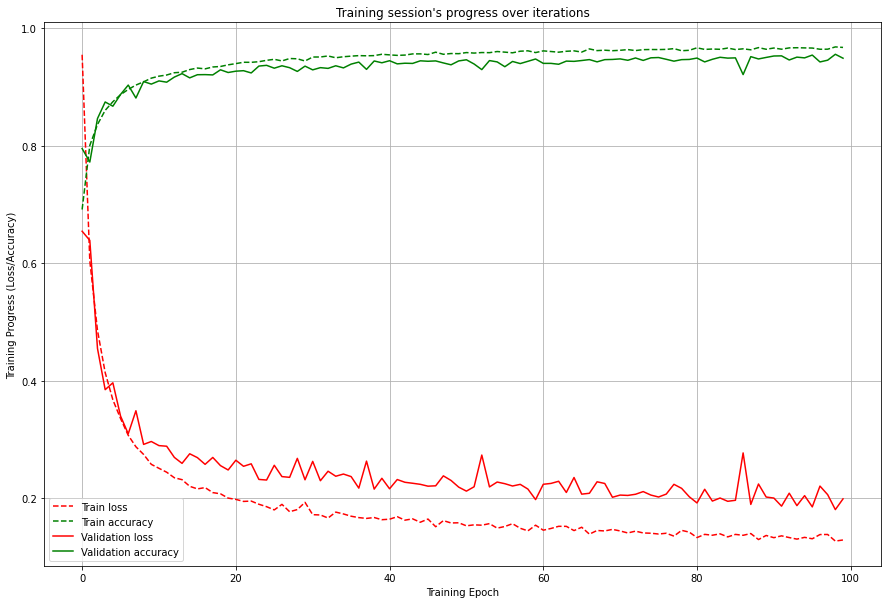

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_28 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_28 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 dense_56 (Dense)            (None, 64)                32832     
                                                                 
 dense_57 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1626 - accuracy: 0.9565 - val_loss: 0.2224 - val_accuracy: 0.9420
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1566 - accuracy: 0.9586 - val_loss: 0.2317 - val_accuracy: 0.9418
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1607 - accuracy: 0.9567 - val_loss: 0.2482 - val_accuracy: 0.9353
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1578 - accuracy: 0.9579 - val_loss: 0.2757 - val_accuracy: 0.9293
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1518 - accuracy: 0.9607 - val_loss: 0.2454 - val_accuracy: 0.9345
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1583 - accuracy: 0.9583 - val_loss: 0.2511 - val_accuracy: 0.9323
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1547 - accuracy: 0.9601 - val_loss: 0.2203 - val_ac

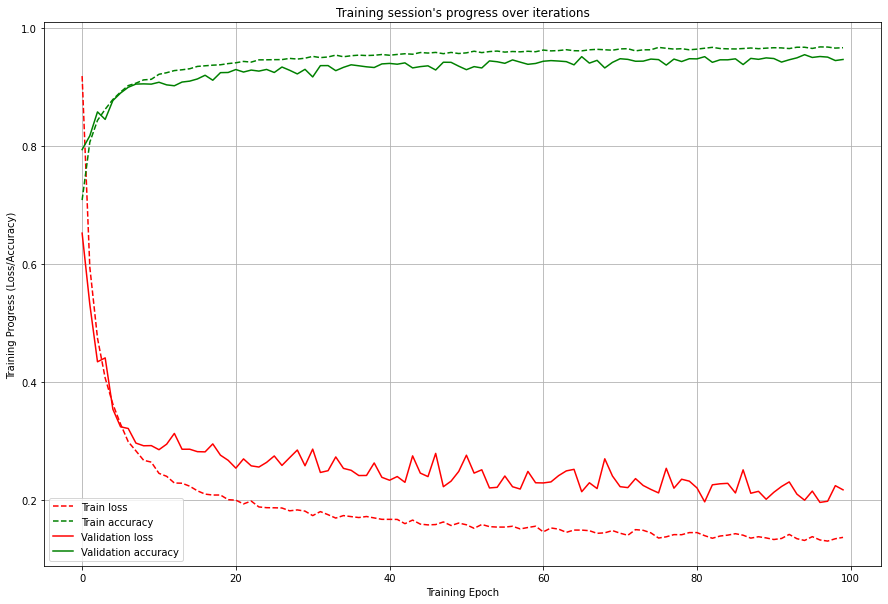

 ..after sliding and reshaping, train data: inputs (59800, 3, 100), targets (59800, 12)
 ..after sliding and reshaping, test data : inputs (899, 3, 100), targets (899, 12)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_29 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_29 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_58 (Dense)            (None, 64)                32832     
                                                                 
 dense_59 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9581 - val_loss: 0.2372 - val_accuracy: 0.9423
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1606 - accuracy: 0.9582 - val_loss: 0.2314 - val_accuracy: 0.9410
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1536 - accuracy: 0.9609 - val_loss: 0.2545 - val_accuracy: 0.9315
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1544 - accuracy: 0.9598 - val_loss: 0.2324 - val_accuracy: 0.9440
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1571 - accuracy: 0.9583 - val_loss: 0.2403 - val_accuracy: 0.9403
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1557 - accuracy: 0.9593 - val_loss: 0.2333 - val_accuracy: 0.9426
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1514 - accuracy: 0.9610 - val_loss: 0.2242 - val_ac

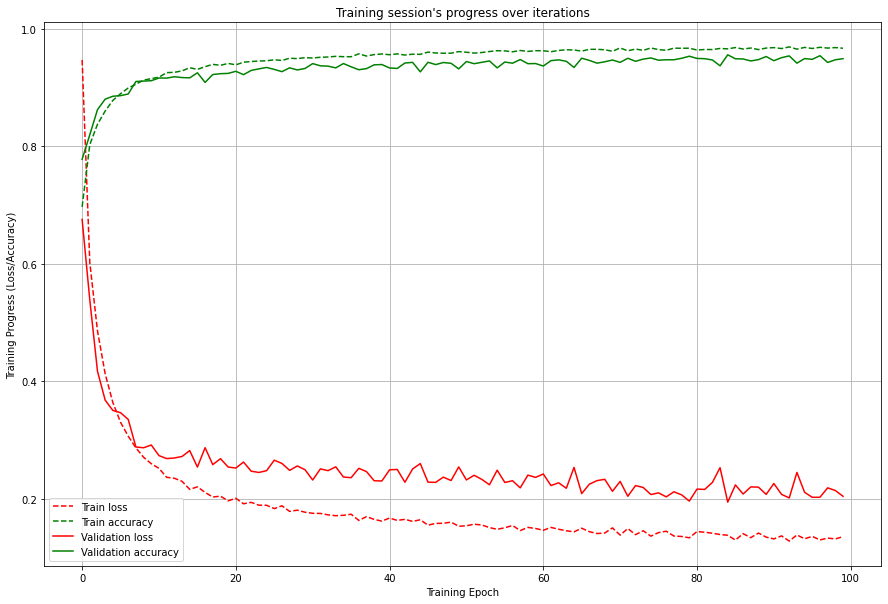

 ..after sliding and reshaping, train data: inputs (59856, 3, 100), targets (59856, 12)
 ..after sliding and reshaping, test data : inputs (843, 3, 100), targets (843, 12)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_30 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_30 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_60 (Dense)            (None, 64)                32832     
                                                                 
 dense_61 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1697 - accuracy: 0.9554 - val_loss: 0.2307 - val_accuracy: 0.9379
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1563 - accuracy: 0.9592 - val_loss: 0.2384 - val_accuracy: 0.9393
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1585 - accuracy: 0.9582 - val_loss: 0.2230 - val_accuracy: 0.9419
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1579 - accuracy: 0.9582 - val_loss: 0.2489 - val_accuracy: 0.9350
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9575 - val_loss: 0.2446 - val_accuracy: 0.9369
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1598 - accuracy: 0.9578 - val_loss: 0.2713 - val_accuracy: 0.9305
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1616 - accuracy: 0.9571 - val_loss: 0.2440 - val_ac

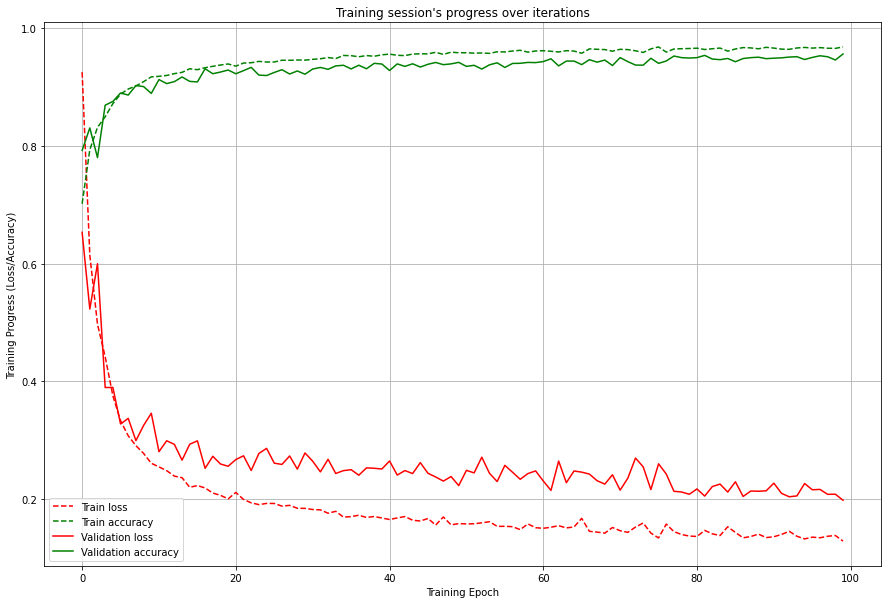

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_31 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_62 (Dense)            (None, 64)                32832     
                                                                 
 dense_63 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1578 - accuracy: 0.9583 - val_loss: 0.2439 - val_accuracy: 0.9391
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1625 - accuracy: 0.9563 - val_loss: 0.2405 - val_accuracy: 0.9382
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1545 - accuracy: 0.9601 - val_loss: 0.2286 - val_accuracy: 0.9372
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1589 - accuracy: 0.9579 - val_loss: 0.2330 - val_accuracy: 0.9393
Epoch 52/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1563 - accuracy: 0.9590 - val_loss: 0.2225 - val_accuracy: 0.9436
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1483 - accuracy: 0.9618 - val_loss: 0.2294 - val_accuracy: 0.9421
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1551 - accuracy: 0.9590 - val_loss: 0.2178 - val_ac

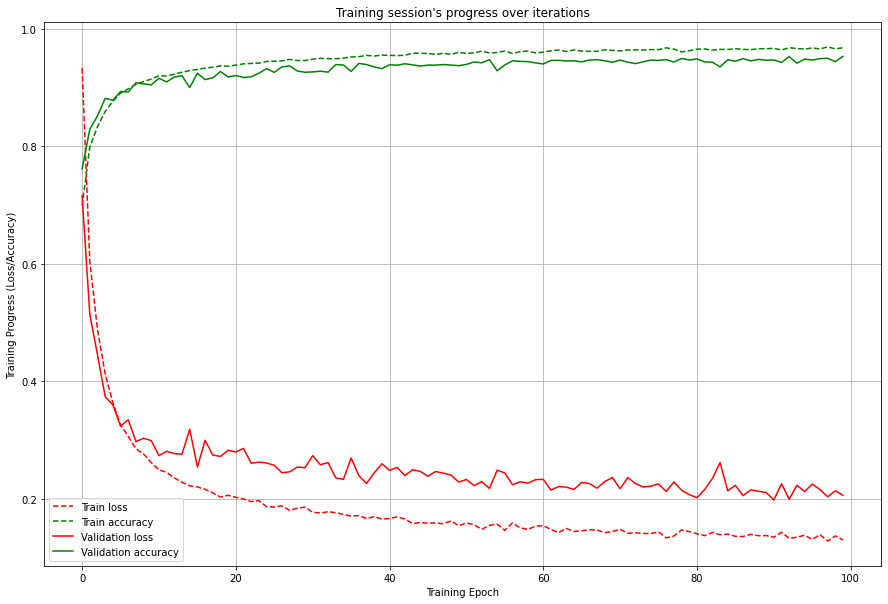

 ..after sliding and reshaping, train data: inputs (59801, 3, 100), targets (59801, 12)
 ..after sliding and reshaping, test data : inputs (898, 3, 100), targets (898, 12)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_32 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_32 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                32832     
                                                                 
 dense_65 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1646 - accuracy: 0.9558 - val_loss: 0.2278 - val_accuracy: 0.9437
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1552 - accuracy: 0.9592 - val_loss: 0.2477 - val_accuracy: 0.9416
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1593 - accuracy: 0.9591 - val_loss: 0.2215 - val_accuracy: 0.9430
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1538 - accuracy: 0.9596 - val_loss: 0.2290 - val_accuracy: 0.9416
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1545 - accuracy: 0.9597 - val_loss: 0.2206 - val_accuracy: 0.9467
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9589 - val_loss: 0.2153 - val_accuracy: 0.9475
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1472 - accuracy: 0.9638 - val_loss: 0.2308 - val_ac

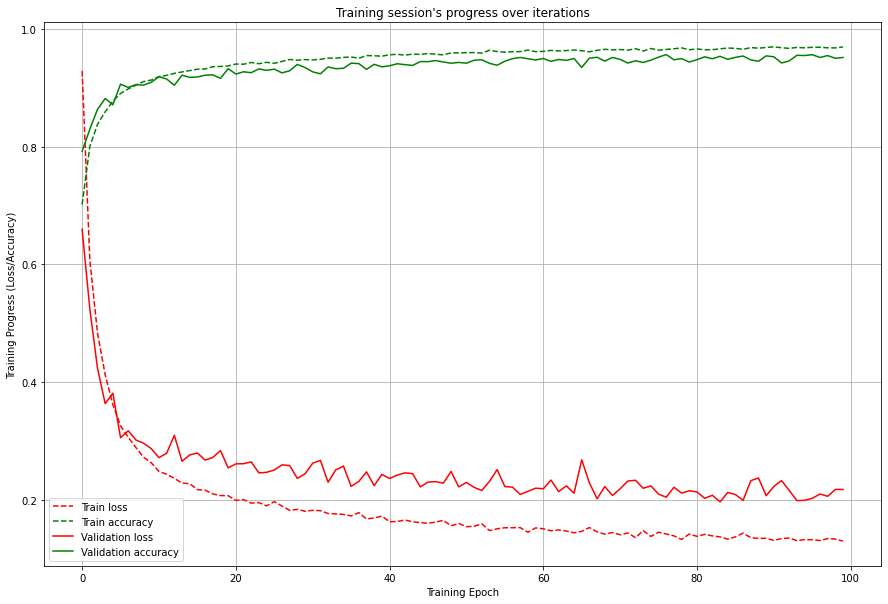

 ..after sliding and reshaping, train data: inputs (59780, 3, 100), targets (59780, 12)
 ..after sliding and reshaping, test data : inputs (919, 3, 100), targets (919, 12)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_33 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_33 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_66 (Dense)            (None, 64)                32832     
                                                                 
 dense_67 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1584 - accuracy: 0.9574 - val_loss: 0.2382 - val_accuracy: 0.9380
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9571 - val_loss: 0.2381 - val_accuracy: 0.9381
Epoch 50/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1619 - accuracy: 0.9575 - val_loss: 0.2276 - val_accuracy: 0.9407
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9590 - val_loss: 0.2083 - val_accuracy: 0.9458
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1541 - accuracy: 0.9583 - val_loss: 0.2251 - val_accuracy: 0.9401
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1502 - accuracy: 0.9608 - val_loss: 0.2366 - val_accuracy: 0.9373
Epoch 54/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1551 - accuracy: 0.9586 - val_loss: 0.2135 - val_ac

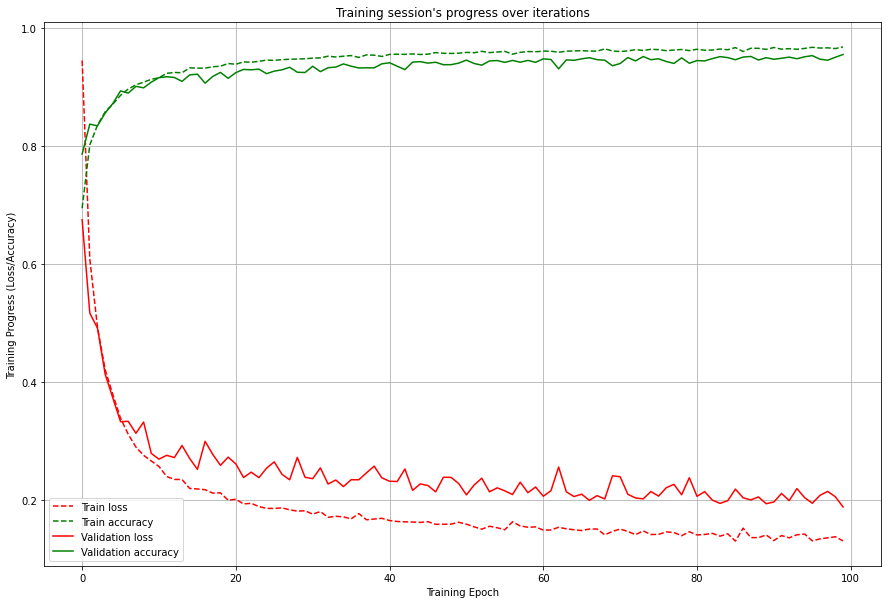

 ..after sliding and reshaping, train data: inputs (59802, 3, 100), targets (59802, 12)
 ..after sliding and reshaping, test data : inputs (896, 3, 100), targets (896, 12)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_34 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_34 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_68 (Dense)            (None, 64)                32832     
                                                                 
 dense_69 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9583 - val_loss: 0.2461 - val_accuracy: 0.9364
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1644 - accuracy: 0.9572 - val_loss: 0.2333 - val_accuracy: 0.9379
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1595 - accuracy: 0.9575 - val_loss: 0.2172 - val_accuracy: 0.9448
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1561 - accuracy: 0.9585 - val_loss: 0.2658 - val_accuracy: 0.9322
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9584 - val_loss: 0.2301 - val_accuracy: 0.9354
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1536 - accuracy: 0.9600 - val_loss: 0.2458 - val_accuracy: 0.9380
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9604 - val_loss: 0.2476 - val_ac

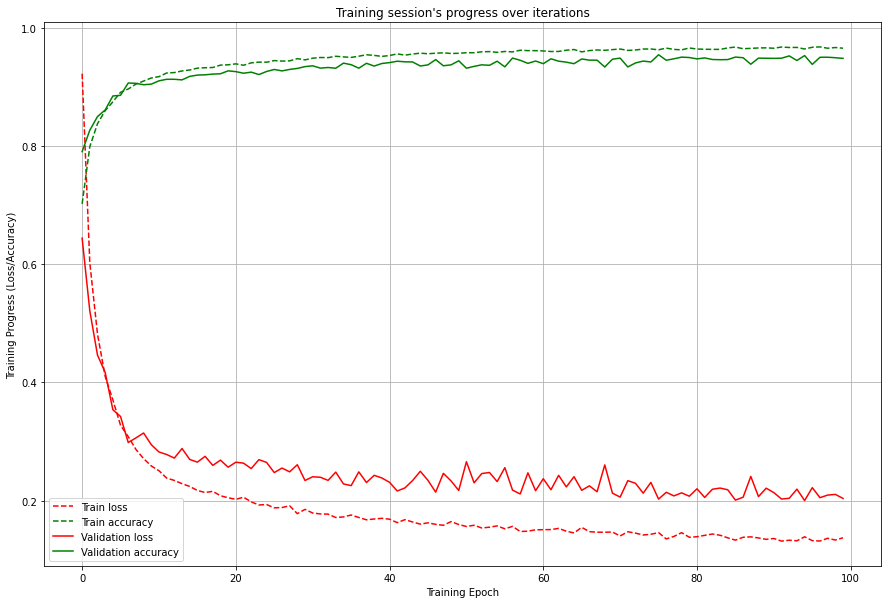

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_35 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_35 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_35 (Dropout)        (None, 512)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                32832     
                                                                 
 dense_71 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9602 - val_loss: 0.2364 - val_accuracy: 0.9389
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1500 - accuracy: 0.9612 - val_loss: 0.2189 - val_accuracy: 0.9439
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1531 - accuracy: 0.9603 - val_loss: 0.2389 - val_accuracy: 0.9389
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1538 - accuracy: 0.9615 - val_loss: 0.2149 - val_accuracy: 0.9421
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1519 - accuracy: 0.9614 - val_loss: 0.2176 - val_accuracy: 0.9444
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1472 - accuracy: 0.9638 - val_loss: 0.2203 - val_accuracy: 0.9472
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1495 - accuracy: 0.9608 - val_loss: 0.2002 - val_ac

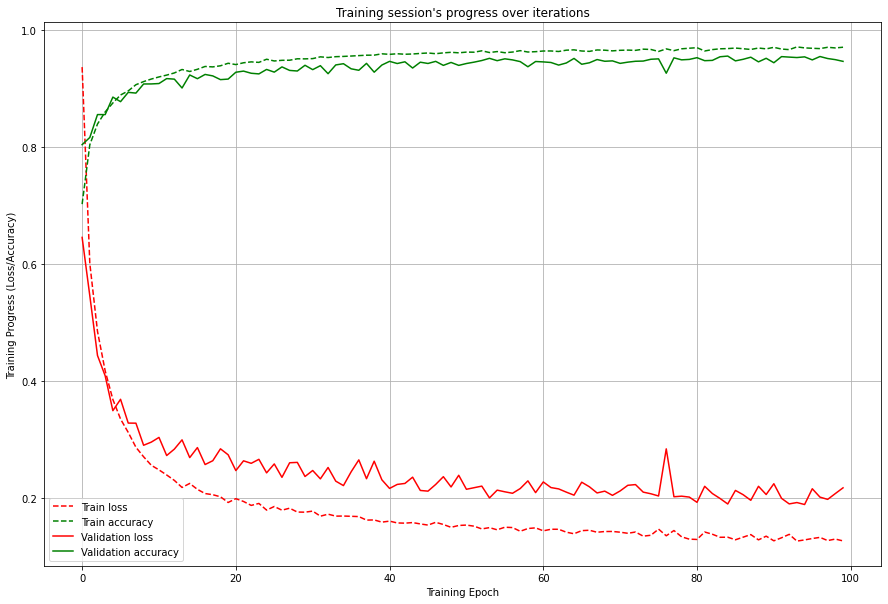

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_36 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_36 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_72 (Dense)            (None, 64)                32832     
                                                                 
 dense_73 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1585 - accuracy: 0.9579 - val_loss: 0.2304 - val_accuracy: 0.9452
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1554 - accuracy: 0.9599 - val_loss: 0.2390 - val_accuracy: 0.9405
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1629 - accuracy: 0.9567 - val_loss: 0.2208 - val_accuracy: 0.9458
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1518 - accuracy: 0.9610 - val_loss: 0.2359 - val_accuracy: 0.9435
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1594 - accuracy: 0.9588 - val_loss: 0.2212 - val_accuracy: 0.9454
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1544 - accuracy: 0.9603 - val_loss: 0.2177 - val_accuracy: 0.9465
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1478 - accuracy: 0.9628 - val_loss: 0.2319 - val_ac

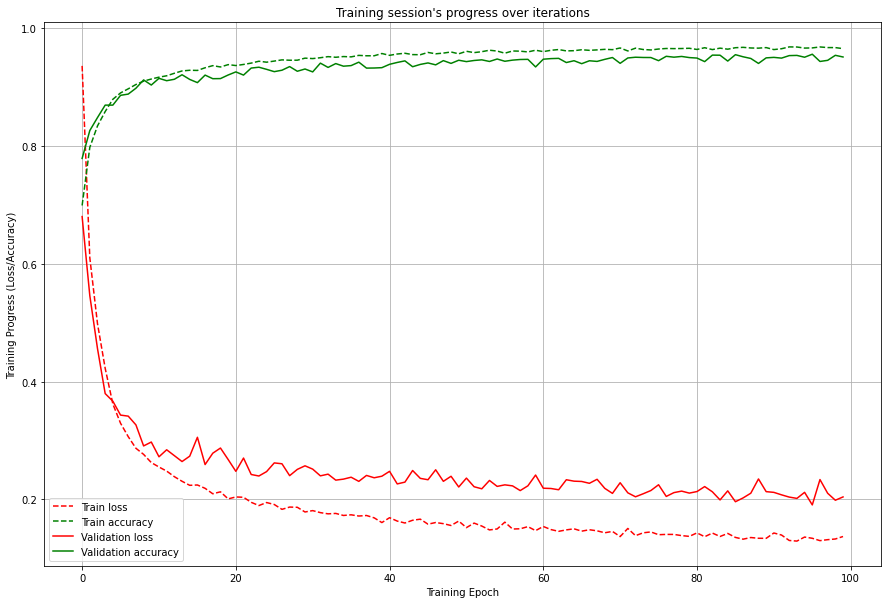

 ..after sliding and reshaping, train data: inputs (59802, 3, 100), targets (59802, 12)
 ..after sliding and reshaping, test data : inputs (897, 3, 100), targets (897, 12)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_37 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_37 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_37 (Dropout)        (None, 512)               0         
                                                                 
 dense_74 (Dense)            (None, 64)                32832     
                                                                 
 dense_75 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1586 - accuracy: 0.9572 - val_loss: 0.2515 - val_accuracy: 0.9454
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1649 - accuracy: 0.9549 - val_loss: 0.2237 - val_accuracy: 0.9447
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1575 - accuracy: 0.9579 - val_loss: 0.2323 - val_accuracy: 0.9433
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1568 - accuracy: 0.9576 - val_loss: 0.2370 - val_accuracy: 0.9405
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1595 - accuracy: 0.9574 - val_loss: 0.2126 - val_accuracy: 0.9459
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1563 - accuracy: 0.9589 - val_loss: 0.2316 - val_accuracy: 0.9415
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1557 - accuracy: 0.9580 - val_loss: 0.2373 - val_ac

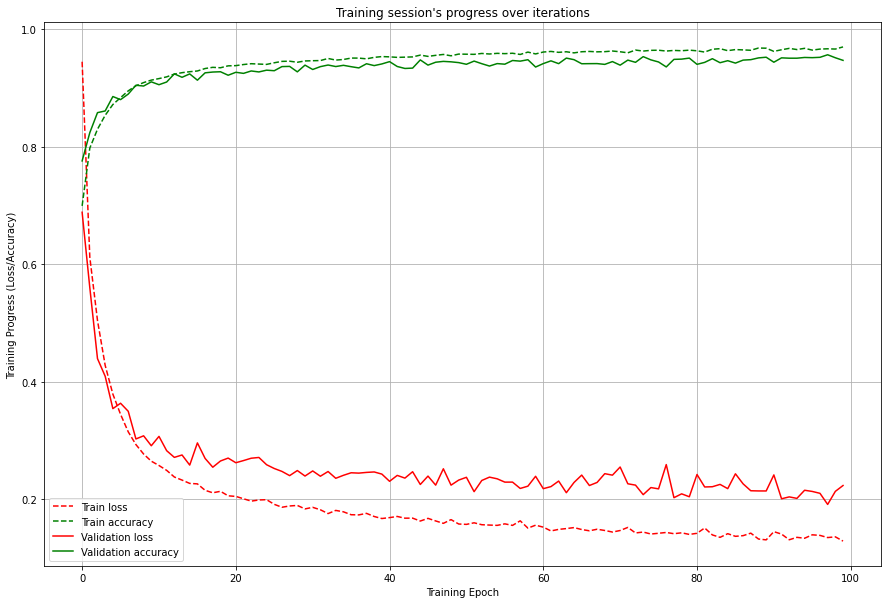

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_38 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 dense_76 (Dense)            (None, 64)                32832     
                                                                 
 dense_77 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1577 - accuracy: 0.9584 - val_loss: 0.2175 - val_accuracy: 0.9466
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1557 - accuracy: 0.9597 - val_loss: 0.2124 - val_accuracy: 0.9443
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1556 - accuracy: 0.9588 - val_loss: 0.2197 - val_accuracy: 0.9446
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1579 - accuracy: 0.9589 - val_loss: 0.2372 - val_accuracy: 0.9394
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9592 - val_loss: 0.2121 - val_accuracy: 0.9459
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1567 - accuracy: 0.9586 - val_loss: 0.2225 - val_accuracy: 0.9437
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9599 - val_loss: 0.2187 - val_ac

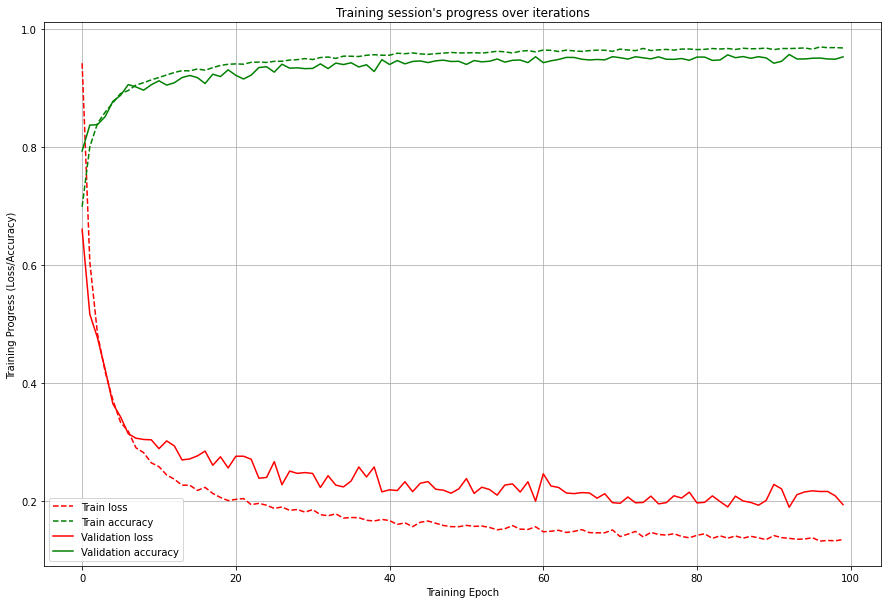

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_39 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_39 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_39 (Dropout)        (None, 512)               0         
                                                                 
 dense_78 (Dense)            (None, 64)                32832     
                                                                 
 dense_79 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1547 - accuracy: 0.9594 - val_loss: 0.2335 - val_accuracy: 0.9382
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1573 - accuracy: 0.9588 - val_loss: 0.2240 - val_accuracy: 0.9493
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1581 - accuracy: 0.9588 - val_loss: 0.2195 - val_accuracy: 0.9501
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1531 - accuracy: 0.9603 - val_loss: 0.2222 - val_accuracy: 0.9466
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9586 - val_loss: 0.2233 - val_accuracy: 0.9437
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1541 - accuracy: 0.9601 - val_loss: 0.2178 - val_accuracy: 0.9431
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1521 - accuracy: 0.9601 - val_loss: 0.2177 - val_ac

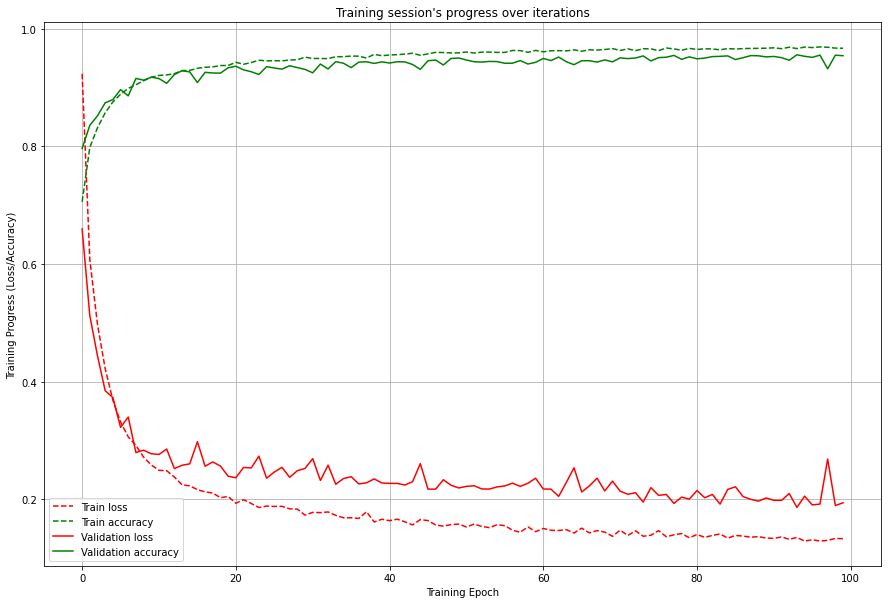

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_40 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_40 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_40 (Dropout)        (None, 512)               0         
                                                                 
 dense_80 (Dense)            (None, 64)                32832     
                                                                 
 dense_81 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1569 - accuracy: 0.9590 - val_loss: 0.2546 - val_accuracy: 0.9354
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1591 - accuracy: 0.9594 - val_loss: 0.2427 - val_accuracy: 0.9374
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9602 - val_loss: 0.2384 - val_accuracy: 0.9402
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1584 - accuracy: 0.9587 - val_loss: 0.2402 - val_accuracy: 0.9406
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1542 - accuracy: 0.9611 - val_loss: 0.2622 - val_accuracy: 0.9314
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1547 - accuracy: 0.9605 - val_loss: 0.2251 - val_accuracy: 0.9453
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1524 - accuracy: 0.9610 - val_loss: 0.2243 - val_ac

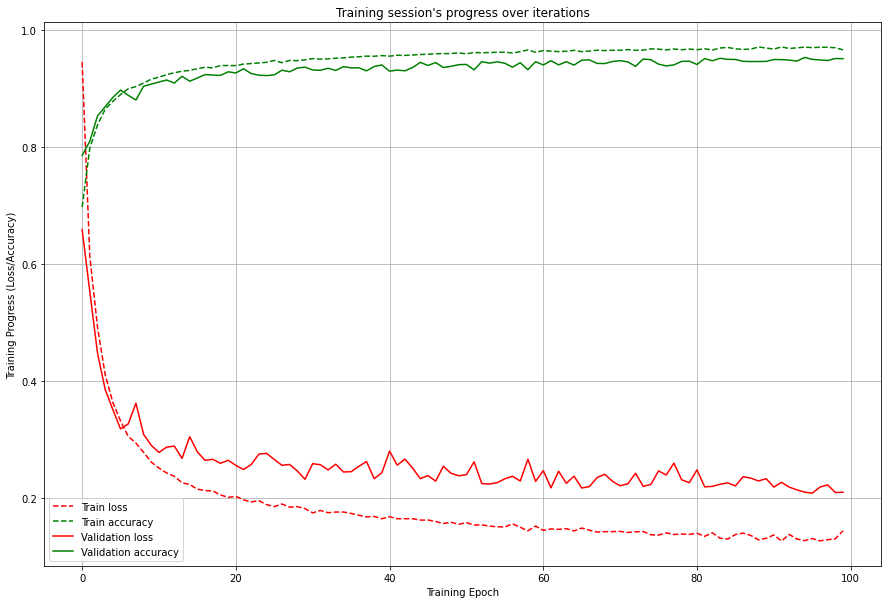

 ..after sliding and reshaping, train data: inputs (59875, 3, 100), targets (59875, 12)
 ..after sliding and reshaping, test data : inputs (823, 3, 100), targets (823, 12)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_41 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_41 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_41 (Dropout)        (None, 512)               0         
                                                                 
 dense_82 (Dense)            (None, 64)                32832     
                                                                 
 dense_83 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1596 - accuracy: 0.9572 - val_loss: 0.2454 - val_accuracy: 0.9382
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1652 - accuracy: 0.9540 - val_loss: 0.2345 - val_accuracy: 0.9415
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1598 - accuracy: 0.9568 - val_loss: 0.2451 - val_accuracy: 0.9406
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1568 - accuracy: 0.9584 - val_loss: 0.2549 - val_accuracy: 0.9411
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9597 - val_loss: 0.2294 - val_accuracy: 0.9429
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1588 - accuracy: 0.9574 - val_loss: 0.2722 - val_accuracy: 0.9385
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1575 - accuracy: 0.9580 - val_loss: 0.2171 - val_ac

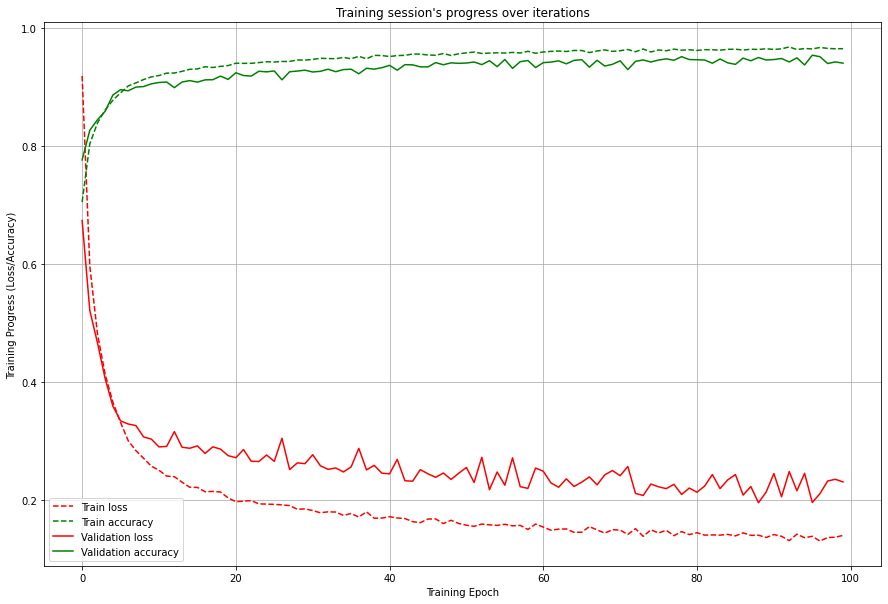

 ..after sliding and reshaping, train data: inputs (60031, 3, 100), targets (60031, 12)
 ..after sliding and reshaping, test data : inputs (668, 3, 100), targets (668, 12)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_42 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_42 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_42 (Dropout)        (None, 512)               0         
                                                                 
 dense_84 (Dense)            (None, 64)                32832     
                                                                 
 dense_85 (De

Epoch 48/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1592 - accuracy: 0.9577 - val_loss: 0.2308 - val_accuracy: 0.9409
Epoch 49/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1596 - accuracy: 0.9579 - val_loss: 0.2138 - val_accuracy: 0.9435
Epoch 50/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1619 - accuracy: 0.9569 - val_loss: 0.2337 - val_accuracy: 0.9334
Epoch 51/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1642 - accuracy: 0.9570 - val_loss: 0.2124 - val_accuracy: 0.9405
Epoch 52/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1559 - accuracy: 0.9592 - val_loss: 0.2103 - val_accuracy: 0.9433
Epoch 53/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1545 - accuracy: 0.9601 - val_loss: 0.2111 - val_accuracy: 0.9461
Epoch 54/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1583 - accuracy: 0.9588 - val_loss: 0.2512 - val_ac

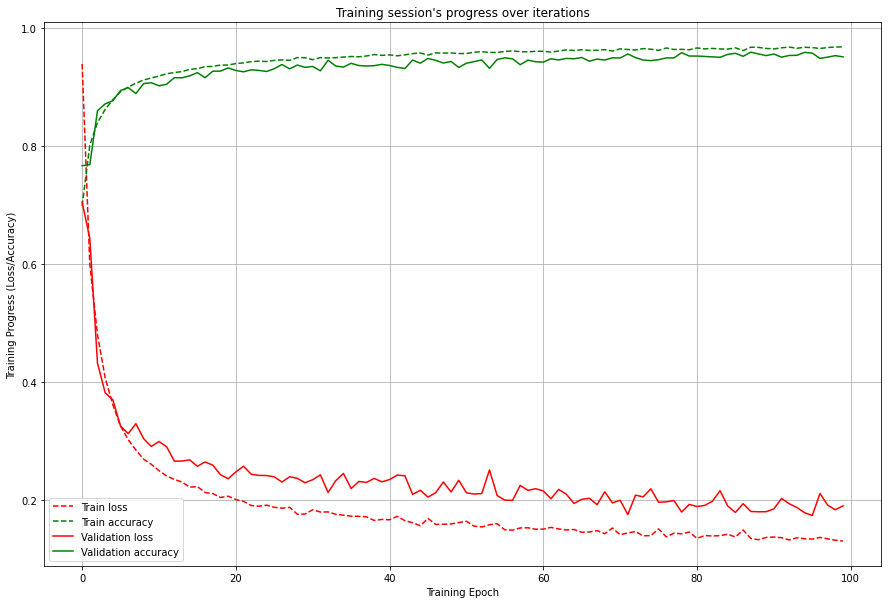

 ..after sliding and reshaping, train data: inputs (59879, 3, 100), targets (59879, 12)
 ..after sliding and reshaping, test data : inputs (820, 3, 100), targets (820, 12)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_43 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_43 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_43 (Dropout)        (None, 512)               0         
                                                                 
 dense_86 (Dense)            (None, 64)                32832     
                                                                 
 dense_87 (De

Epoch 48/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1499 - accuracy: 0.9614 - val_loss: 0.2195 - val_accuracy: 0.9447
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9588 - val_loss: 0.2605 - val_accuracy: 0.9406
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1540 - accuracy: 0.9609 - val_loss: 0.2303 - val_accuracy: 0.9457
Epoch 51/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1542 - accuracy: 0.9612 - val_loss: 0.2196 - val_accuracy: 0.9467
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9611 - val_loss: 0.2227 - val_accuracy: 0.9483
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1495 - accuracy: 0.9627 - val_loss: 0.2337 - val_accuracy: 0.9473
Epoch 54/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1509 - accuracy: 0.9606 - val_loss: 0.2690 - val_ac

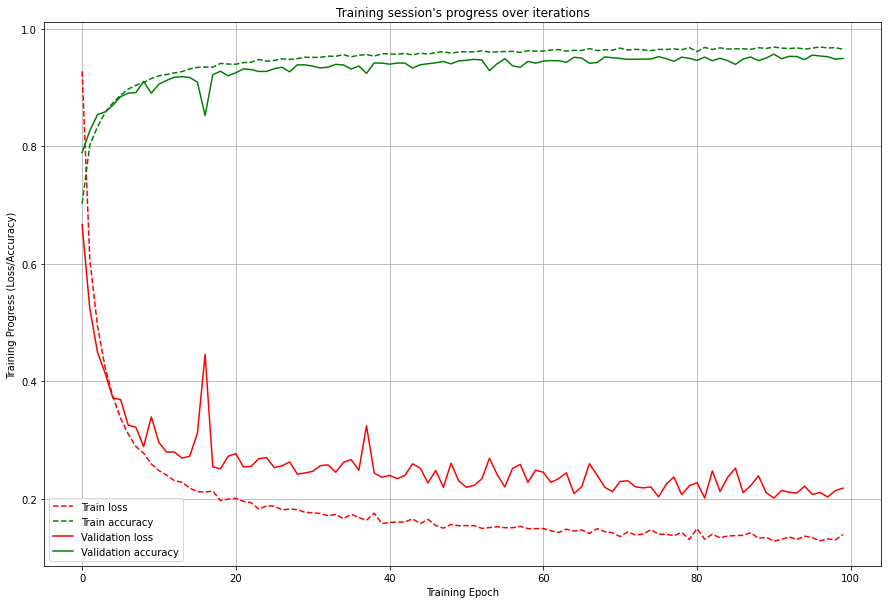

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_44 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_44 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_44 (Dropout)        (None, 512)               0         
                                                                 
 dense_88 (Dense)            (None, 64)                32832     
                                                                 
 dense_89 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1669 - accuracy: 0.9550 - val_loss: 0.2418 - val_accuracy: 0.9406
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1590 - accuracy: 0.9571 - val_loss: 0.2357 - val_accuracy: 0.9429
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1624 - accuracy: 0.9558 - val_loss: 0.2376 - val_accuracy: 0.9388
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1623 - accuracy: 0.9560 - val_loss: 0.2451 - val_accuracy: 0.9411
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1575 - accuracy: 0.9587 - val_loss: 0.2324 - val_accuracy: 0.9403
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1596 - accuracy: 0.9571 - val_loss: 0.2377 - val_accuracy: 0.9408
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1610 - accuracy: 0.9579 - val_loss: 0.2460 - val_ac

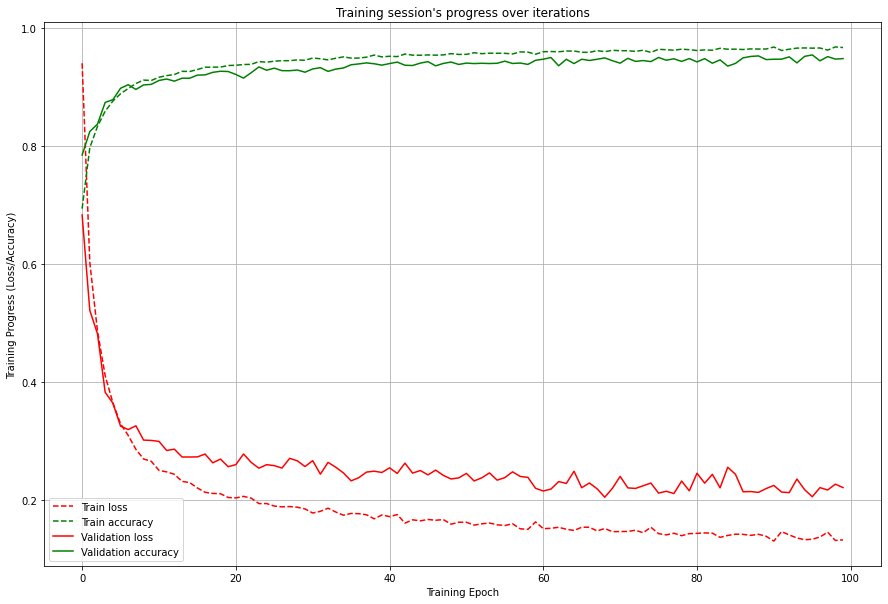

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_45 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_45 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_45 (Dropout)        (None, 512)               0         
                                                                 
 dense_90 (Dense)            (None, 64)                32832     
                                                                 
 dense_91 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1651 - accuracy: 0.9548 - val_loss: 0.2348 - val_accuracy: 0.9412
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1608 - accuracy: 0.9555 - val_loss: 0.2219 - val_accuracy: 0.9472
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1616 - accuracy: 0.9551 - val_loss: 0.2386 - val_accuracy: 0.9425
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1626 - accuracy: 0.9560 - val_loss: 0.2229 - val_accuracy: 0.9462
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1592 - accuracy: 0.9569 - val_loss: 0.2213 - val_accuracy: 0.9460
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1563 - accuracy: 0.9582 - val_loss: 0.2248 - val_accuracy: 0.9428
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1571 - accuracy: 0.9574 - val_loss: 0.2329 - val_ac

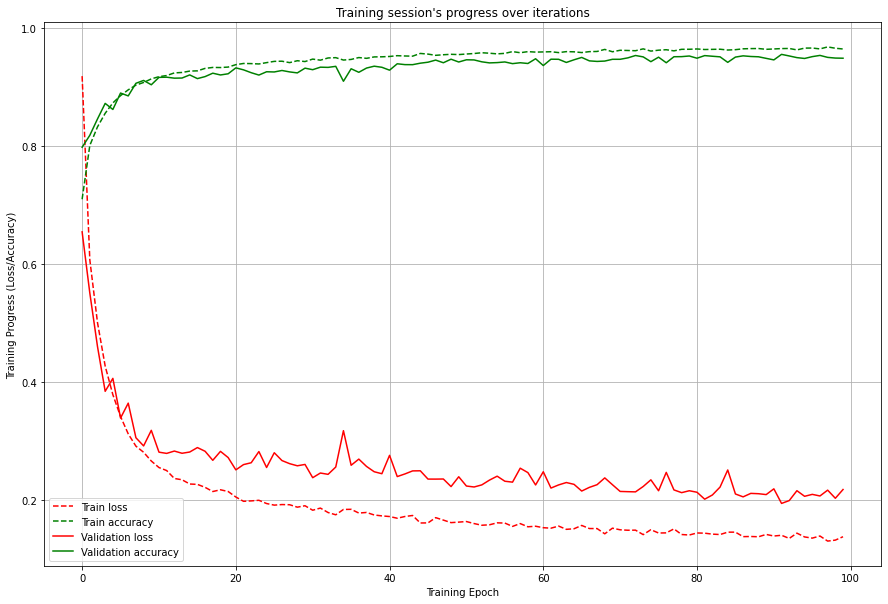

 ..after sliding and reshaping, train data: inputs (59884, 3, 100), targets (59884, 12)
 ..after sliding and reshaping, test data : inputs (815, 3, 100), targets (815, 12)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_46 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_46 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_46 (Dropout)        (None, 512)               0         
                                                                 
 dense_92 (Dense)            (None, 64)                32832     
                                                                 
 dense_93 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9604 - val_loss: 0.2194 - val_accuracy: 0.9461
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1534 - accuracy: 0.9610 - val_loss: 0.2327 - val_accuracy: 0.9376
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9601 - val_loss: 0.2510 - val_accuracy: 0.9347
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1571 - accuracy: 0.9603 - val_loss: 0.2198 - val_accuracy: 0.9459
Epoch 52/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1544 - accuracy: 0.9610 - val_loss: 0.2234 - val_accuracy: 0.9491
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1546 - accuracy: 0.9609 - val_loss: 0.2226 - val_accuracy: 0.9484
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1502 - accuracy: 0.9627 - val_loss: 0.2177 - val_ac

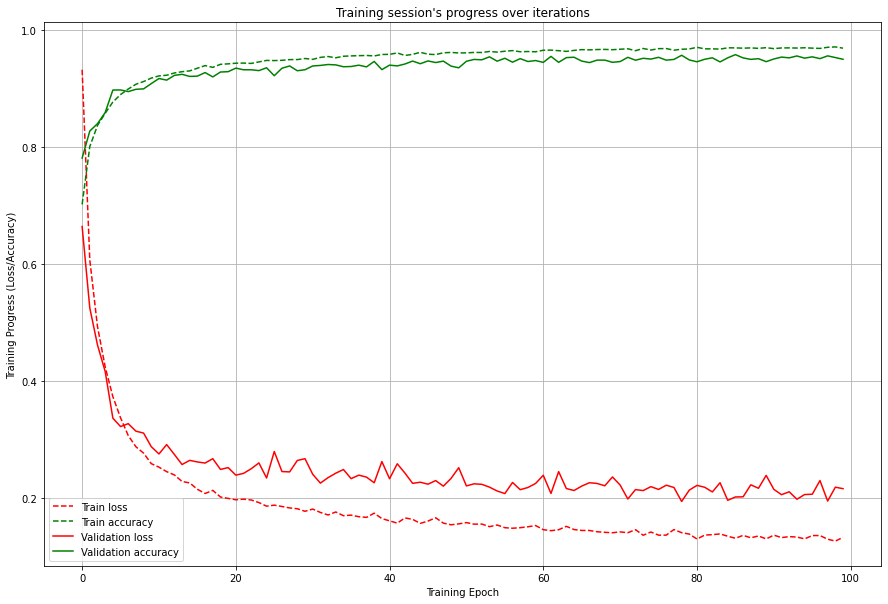

 ..after sliding and reshaping, train data: inputs (59876, 3, 100), targets (59876, 12)
 ..after sliding and reshaping, test data : inputs (823, 3, 100), targets (823, 12)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_47 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_47 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_47 (Dropout)        (None, 512)               0         
                                                                 
 dense_94 (Dense)            (None, 64)                32832     
                                                                 
 dense_95 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1565 - accuracy: 0.9561 - val_loss: 0.2407 - val_accuracy: 0.9307
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1607 - accuracy: 0.9551 - val_loss: 0.2155 - val_accuracy: 0.9427
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1563 - accuracy: 0.9579 - val_loss: 0.2433 - val_accuracy: 0.9329
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1606 - accuracy: 0.9558 - val_loss: 0.2213 - val_accuracy: 0.9445
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9586 - val_loss: 0.2369 - val_accuracy: 0.9402
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1550 - accuracy: 0.9585 - val_loss: 0.2412 - val_accuracy: 0.9345
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1530 - accuracy: 0.9585 - val_loss: 0.2253 - val_ac

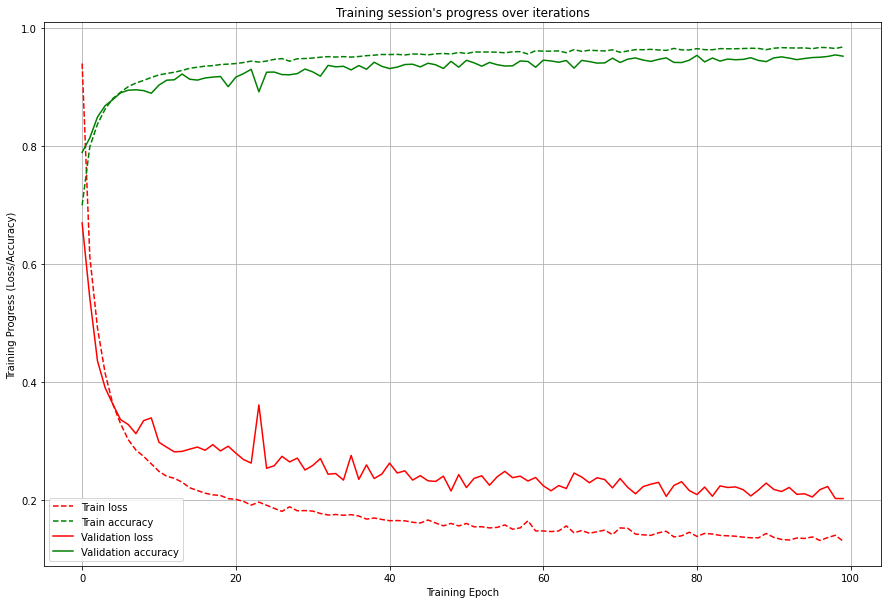

 ..after sliding and reshaping, train data: inputs (59807, 3, 100), targets (59807, 12)
 ..after sliding and reshaping, test data : inputs (892, 3, 100), targets (892, 12)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_48 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_48 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_48 (Dropout)        (None, 512)               0         
                                                                 
 dense_96 (Dense)            (None, 64)                32832     
                                                                 
 dense_97 (De

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1608 - accuracy: 0.9557 - val_loss: 0.2554 - val_accuracy: 0.9314
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1577 - accuracy: 0.9576 - val_loss: 0.2331 - val_accuracy: 0.9437
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1541 - accuracy: 0.9591 - val_loss: 0.2495 - val_accuracy: 0.9360
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1591 - accuracy: 0.9566 - val_loss: 0.2222 - val_accuracy: 0.9394
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1565 - accuracy: 0.9578 - val_loss: 0.2207 - val_accuracy: 0.9468
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1553 - accuracy: 0.9578 - val_loss: 0.2202 - val_accuracy: 0.9458
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1657 - accuracy: 0.9547 - val_loss: 0.2225 - val_ac

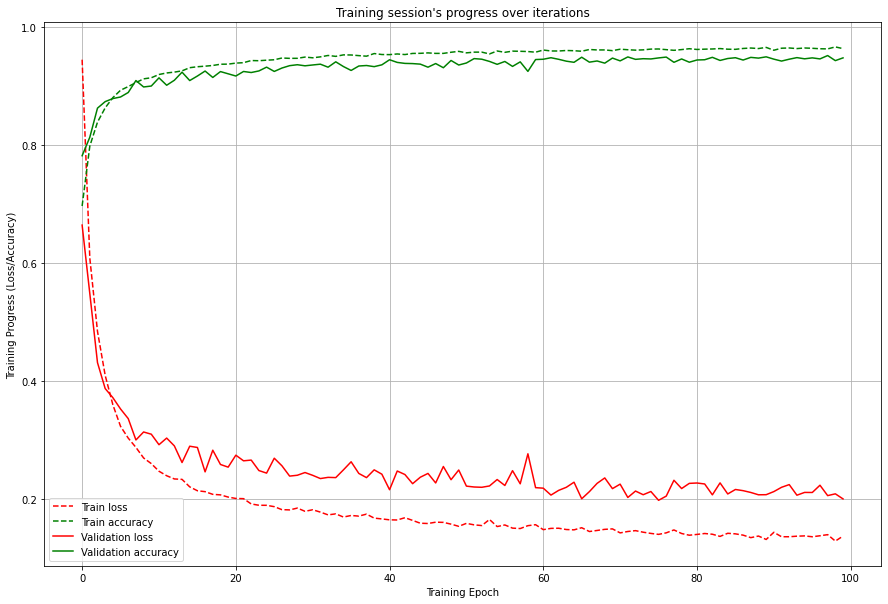

 ..after sliding and reshaping, train data: inputs (59879, 3, 100), targets (59879, 12)
 ..after sliding and reshaping, test data : inputs (820, 3, 100), targets (820, 12)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_49 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_49 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_49 (Dropout)        (None, 512)               0         
                                                                 
 dense_98 (Dense)            (None, 64)                32832     
                                                                 
 dense_99 (De

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1629 - accuracy: 0.9568 - val_loss: 0.2399 - val_accuracy: 0.9413
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9584 - val_loss: 0.2574 - val_accuracy: 0.9337
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1567 - accuracy: 0.9583 - val_loss: 0.2398 - val_accuracy: 0.9430
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1538 - accuracy: 0.9590 - val_loss: 0.2447 - val_accuracy: 0.9395
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1564 - accuracy: 0.9576 - val_loss: 0.2396 - val_accuracy: 0.9363
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1542 - accuracy: 0.9598 - val_loss: 0.2381 - val_accuracy: 0.9410
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1558 - accuracy: 0.9594 - val_loss: 0.2300 - val_ac

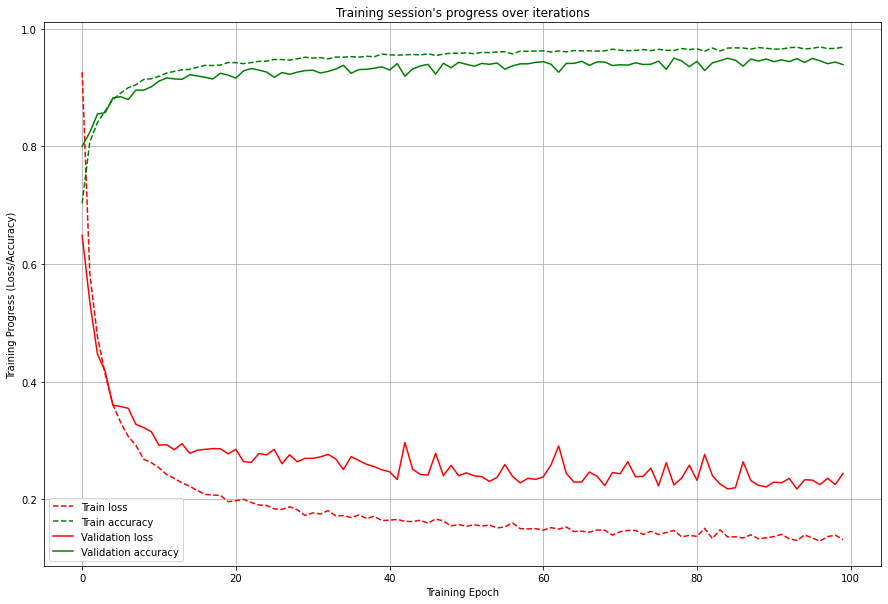

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_50 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_50 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_50 (Dropout)        (None, 512)               0         
                                                                 
 dense_100 (Dense)           (None, 64)                32832     
                                                                 
 dense_101 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1615 - accuracy: 0.9561 - val_loss: 0.2372 - val_accuracy: 0.9421
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1520 - accuracy: 0.9607 - val_loss: 0.2394 - val_accuracy: 0.9373
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1583 - accuracy: 0.9571 - val_loss: 0.2462 - val_accuracy: 0.9365
Epoch 51/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1542 - accuracy: 0.9593 - val_loss: 0.2465 - val_accuracy: 0.9467
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1560 - accuracy: 0.9587 - val_loss: 0.2386 - val_accuracy: 0.9345
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1565 - accuracy: 0.9581 - val_loss: 0.2478 - val_accuracy: 0.9408
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1505 - accuracy: 0.9604 - val_loss: 0.2175 - val_ac

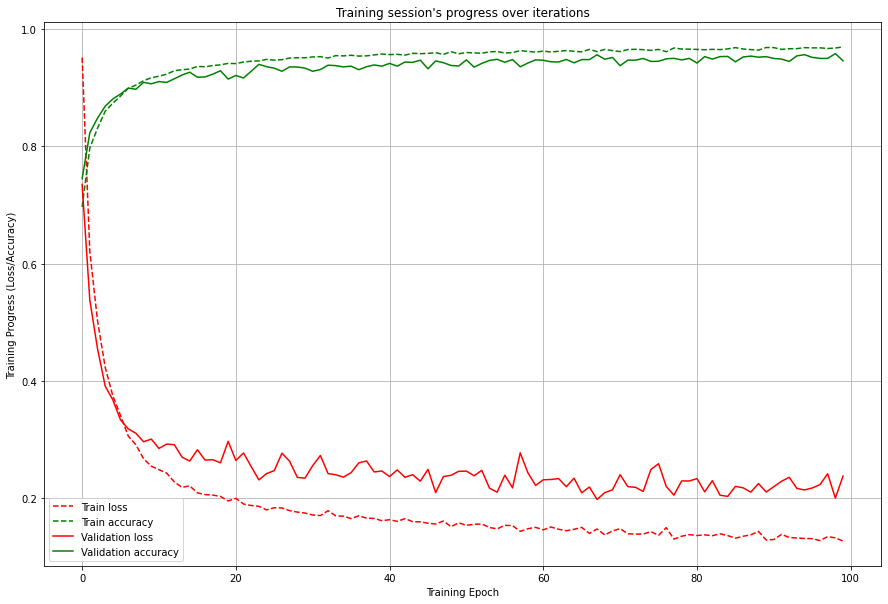

 ..after sliding and reshaping, train data: inputs (59797, 3, 100), targets (59797, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_51 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_51 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_51 (Dropout)        (None, 512)               0         
                                                                 
 dense_102 (Dense)           (None, 64)                32832     
                                                                 
 dense_103 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1625 - accuracy: 0.9581 - val_loss: 0.2116 - val_accuracy: 0.9482
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1545 - accuracy: 0.9606 - val_loss: 0.2045 - val_accuracy: 0.9484
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1485 - accuracy: 0.9609 - val_loss: 0.2063 - val_accuracy: 0.9490
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1591 - accuracy: 0.9585 - val_loss: 0.2228 - val_accuracy: 0.9405
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1622 - accuracy: 0.9575 - val_loss: 0.2239 - val_accuracy: 0.9461
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1565 - accuracy: 0.9598 - val_loss: 0.2158 - val_accuracy: 0.9438
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1508 - accuracy: 0.9622 - val_loss: 0.2060 - val_ac

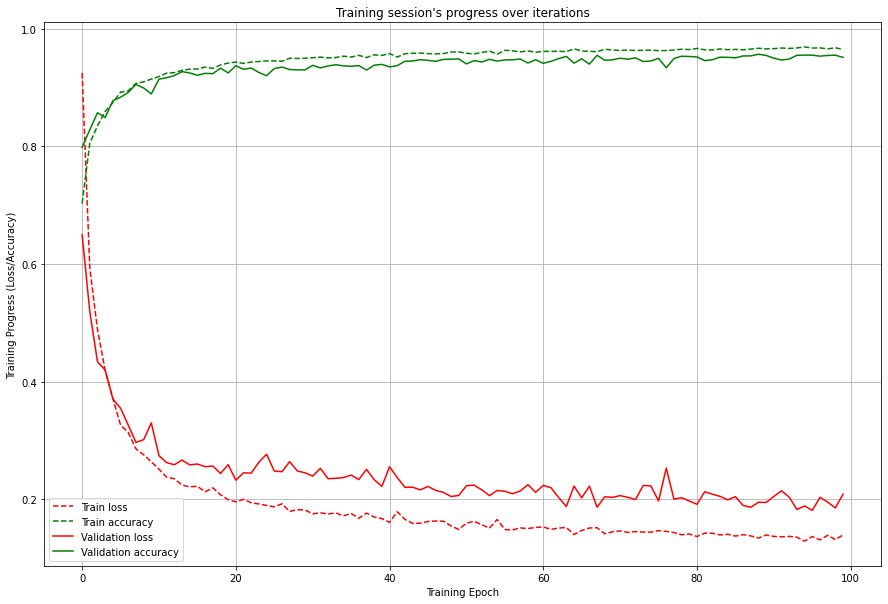

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_52 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_52 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_52 (Dropout)        (None, 512)               0         
                                                                 
 dense_104 (Dense)           (None, 64)                32832     
                                                                 
 dense_105 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9581 - val_loss: 0.2454 - val_accuracy: 0.9351
Epoch 49/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1611 - accuracy: 0.9574 - val_loss: 0.2407 - val_accuracy: 0.9384
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9600 - val_loss: 0.2505 - val_accuracy: 0.9349
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1570 - accuracy: 0.9584 - val_loss: 0.2379 - val_accuracy: 0.9399
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1517 - accuracy: 0.9604 - val_loss: 0.2452 - val_accuracy: 0.9348
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1591 - accuracy: 0.9586 - val_loss: 0.2315 - val_accuracy: 0.9429
Epoch 54/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1538 - accuracy: 0.9607 - val_loss: 0.2352 - val_ac

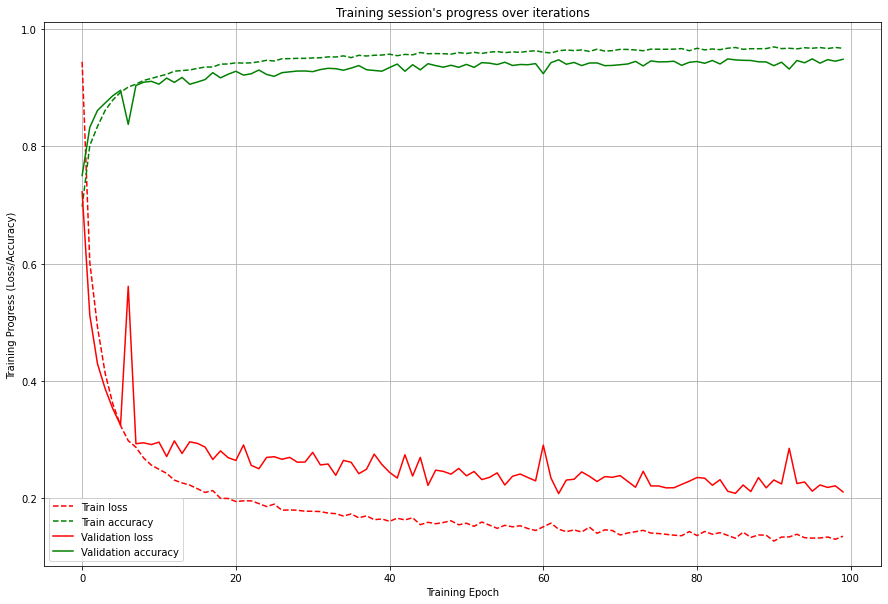

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_53 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_53 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_53 (Dropout)        (None, 512)               0         
                                                                 
 dense_106 (Dense)           (None, 64)                32832     
                                                                 
 dense_107 (D

Epoch 48/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1608 - accuracy: 0.9568 - val_loss: 0.2442 - val_accuracy: 0.9350
Epoch 49/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1565 - accuracy: 0.9583 - val_loss: 0.2352 - val_accuracy: 0.9358
Epoch 50/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1617 - accuracy: 0.9564 - val_loss: 0.2572 - val_accuracy: 0.9246
Epoch 51/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1540 - accuracy: 0.9580 - val_loss: 0.2326 - val_accuracy: 0.9415
Epoch 52/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1568 - accuracy: 0.9592 - val_loss: 0.2432 - val_accuracy: 0.9375
Epoch 53/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1615 - accuracy: 0.9569 - val_loss: 0.3074 - val_accuracy: 0.9200
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1601 - accuracy: 0.9582 - val_loss: 0.2233 - val_ac

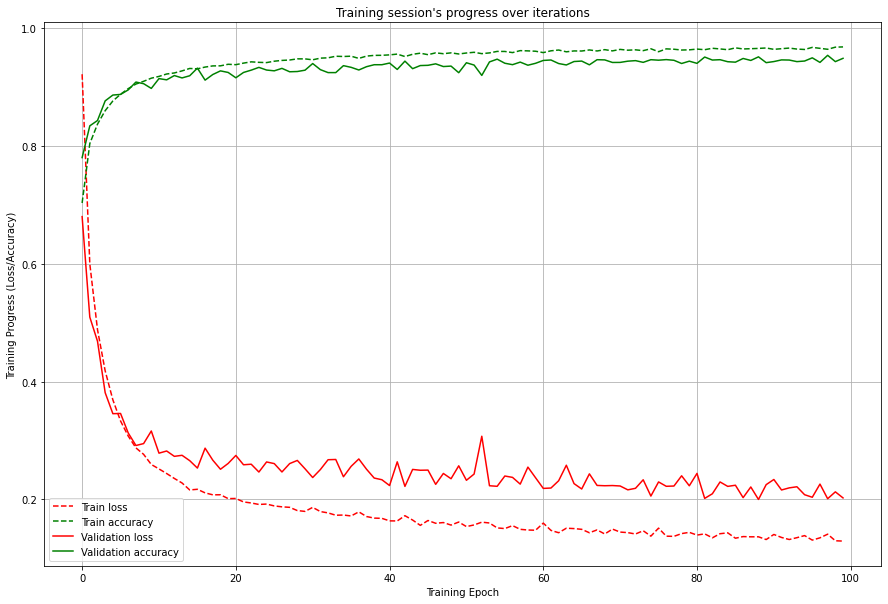

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (827, 3, 100), targets (827, 12)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_54 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_54 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_54 (Dropout)        (None, 512)               0         
                                                                 
 dense_108 (Dense)           (None, 64)                32832     
                                                                 
 dense_109 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1565 - accuracy: 0.9588 - val_loss: 0.2129 - val_accuracy: 0.9390
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1612 - accuracy: 0.9575 - val_loss: 0.2196 - val_accuracy: 0.9413
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1489 - accuracy: 0.9616 - val_loss: 0.2173 - val_accuracy: 0.9437
Epoch 51/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1480 - accuracy: 0.9622 - val_loss: 0.2301 - val_accuracy: 0.9411
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1572 - accuracy: 0.9583 - val_loss: 0.2208 - val_accuracy: 0.9435
Epoch 53/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1513 - accuracy: 0.9607 - val_loss: 0.2020 - val_accuracy: 0.9476
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1469 - accuracy: 0.9630 - val_loss: 0.2127 - val_ac

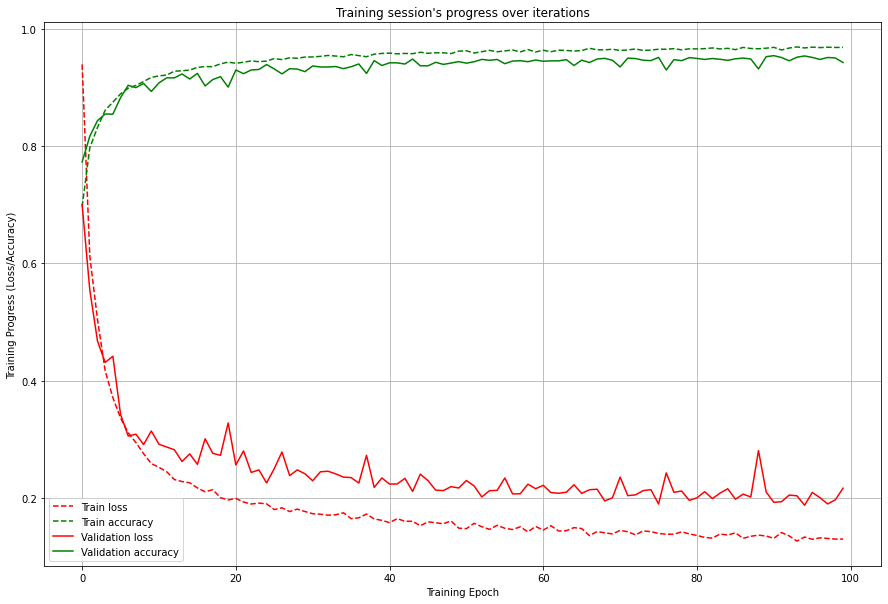

 ..after sliding and reshaping, train data: inputs (59799, 3, 100), targets (59799, 12)
 ..after sliding and reshaping, test data : inputs (899, 3, 100), targets (899, 12)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_55 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_55 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_55 (Dropout)        (None, 512)               0         
                                                                 
 dense_110 (Dense)           (None, 64)                32832     
                                                                 
 dense_111 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1627 - accuracy: 0.9562 - val_loss: 0.2209 - val_accuracy: 0.9471
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1613 - accuracy: 0.9571 - val_loss: 0.2205 - val_accuracy: 0.9384
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1569 - accuracy: 0.9582 - val_loss: 0.2334 - val_accuracy: 0.9420
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1572 - accuracy: 0.9581 - val_loss: 0.2257 - val_accuracy: 0.9436
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1541 - accuracy: 0.9592 - val_loss: 0.2297 - val_accuracy: 0.9417
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1525 - accuracy: 0.9595 - val_loss: 0.2155 - val_accuracy: 0.9446
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1585 - accuracy: 0.9580 - val_loss: 0.2395 - val_ac

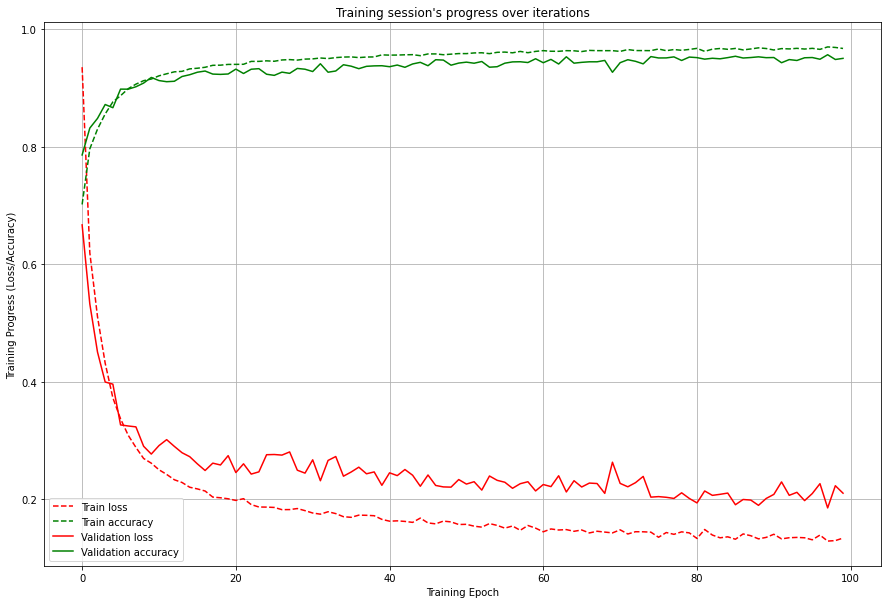

 ..after sliding and reshaping, train data: inputs (59815, 3, 100), targets (59815, 12)
 ..after sliding and reshaping, test data : inputs (884, 3, 100), targets (884, 12)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_56 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_56 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_56 (Dropout)        (None, 512)               0         
                                                                 
 dense_112 (Dense)           (None, 64)                32832     
                                                                 
 dense_113 (D

Epoch 48/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1575 - accuracy: 0.9588 - val_loss: 0.2524 - val_accuracy: 0.9354
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1559 - accuracy: 0.9581 - val_loss: 0.2186 - val_accuracy: 0.9416
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1500 - accuracy: 0.9608 - val_loss: 0.2282 - val_accuracy: 0.9376
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1525 - accuracy: 0.9599 - val_loss: 0.2435 - val_accuracy: 0.9356
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1582 - accuracy: 0.9574 - val_loss: 0.2114 - val_accuracy: 0.9454
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1468 - accuracy: 0.9615 - val_loss: 0.2129 - val_accuracy: 0.9448
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1556 - accuracy: 0.9598 - val_loss: 0.2266 - val_ac

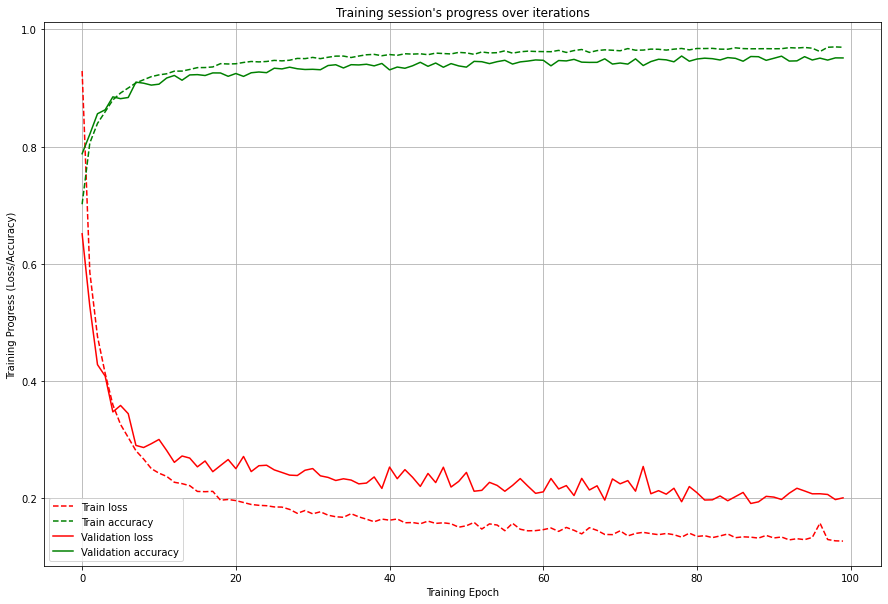

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_57 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_57 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_57 (Dropout)        (None, 512)               0         
                                                                 
 dense_114 (Dense)           (None, 64)                32832     
                                                                 
 dense_115 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1589 - accuracy: 0.9601 - val_loss: 0.2275 - val_accuracy: 0.9420
Epoch 49/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1552 - accuracy: 0.9604 - val_loss: 0.2479 - val_accuracy: 0.9426
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1554 - accuracy: 0.9598 - val_loss: 0.2530 - val_accuracy: 0.9356
Epoch 51/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1506 - accuracy: 0.9616 - val_loss: 0.2388 - val_accuracy: 0.9459
Epoch 52/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1529 - accuracy: 0.9604 - val_loss: 0.2308 - val_accuracy: 0.9415
Epoch 53/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1502 - accuracy: 0.9610 - val_loss: 0.2781 - val_accuracy: 0.9347
Epoch 54/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1534 - accuracy: 0.9608 - val_loss: 0.2507 - val_ac

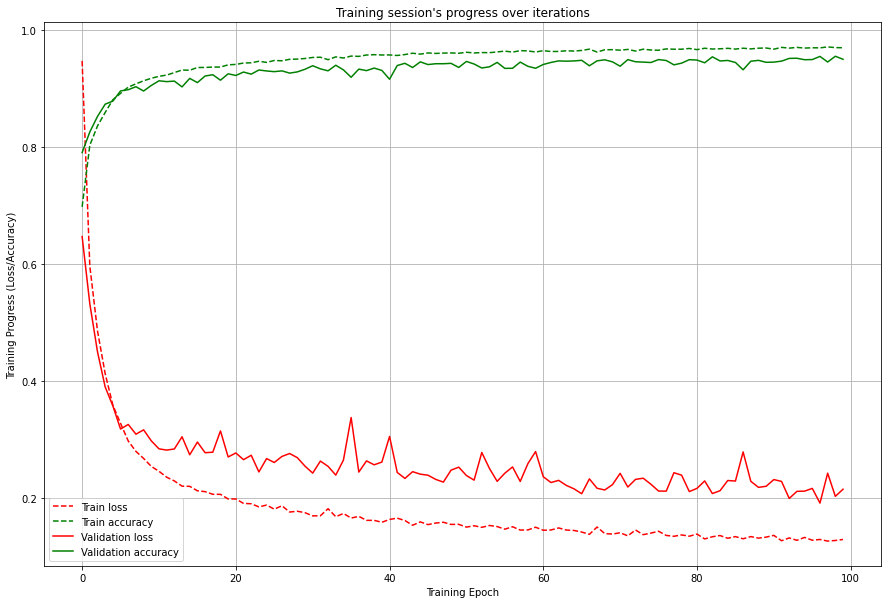

 ..after sliding and reshaping, train data: inputs (59788, 3, 100), targets (59788, 12)
 ..after sliding and reshaping, test data : inputs (911, 3, 100), targets (911, 12)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_58 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_58 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_58 (Dropout)        (None, 512)               0         
                                                                 
 dense_116 (Dense)           (None, 64)                32832     
                                                                 
 dense_117 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1560 - accuracy: 0.9597 - val_loss: 0.2479 - val_accuracy: 0.9344
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1554 - accuracy: 0.9596 - val_loss: 0.2408 - val_accuracy: 0.9359
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1535 - accuracy: 0.9592 - val_loss: 0.2283 - val_accuracy: 0.9405
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1551 - accuracy: 0.9595 - val_loss: 0.2256 - val_accuracy: 0.9408
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1515 - accuracy: 0.9596 - val_loss: 0.2371 - val_accuracy: 0.9350
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9577 - val_loss: 0.2220 - val_accuracy: 0.9440
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1534 - accuracy: 0.9598 - val_loss: 0.2263 - val_ac

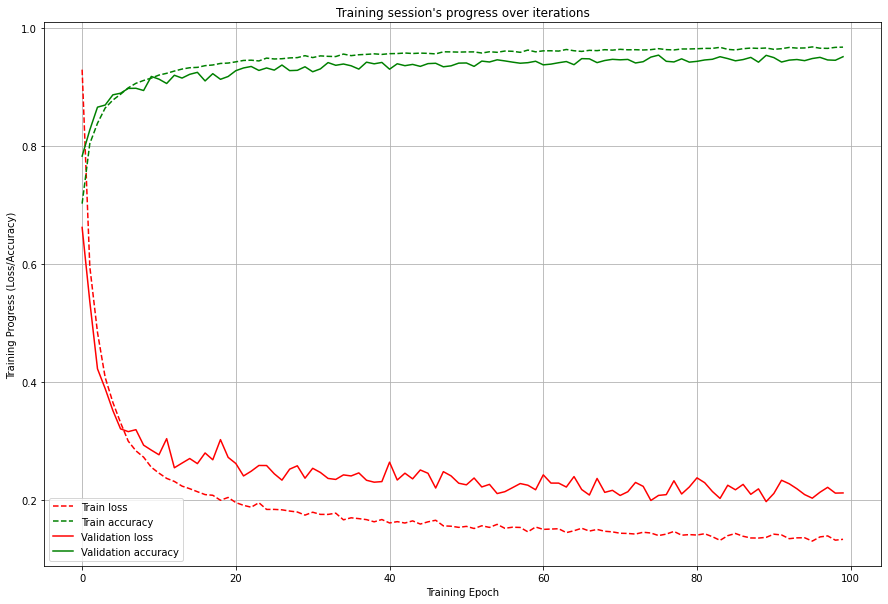

 ..after sliding and reshaping, train data: inputs (59959, 3, 100), targets (59959, 12)
 ..after sliding and reshaping, test data : inputs (740, 3, 100), targets (740, 12)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_59 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_59 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_59 (Dropout)        (None, 512)               0         
                                                                 
 dense_118 (Dense)           (None, 64)                32832     
                                                                 
 dense_119 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1587 - accuracy: 0.9593 - val_loss: 0.2406 - val_accuracy: 0.9406
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9605 - val_loss: 0.2233 - val_accuracy: 0.9427
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1526 - accuracy: 0.9610 - val_loss: 0.2470 - val_accuracy: 0.9425
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1645 - accuracy: 0.9568 - val_loss: 0.2245 - val_accuracy: 0.9465
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1576 - accuracy: 0.9597 - val_loss: 0.2526 - val_accuracy: 0.9384
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1556 - accuracy: 0.9603 - val_loss: 0.2508 - val_accuracy: 0.9414
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1553 - accuracy: 0.9607 - val_loss: 0.2422 - val_ac

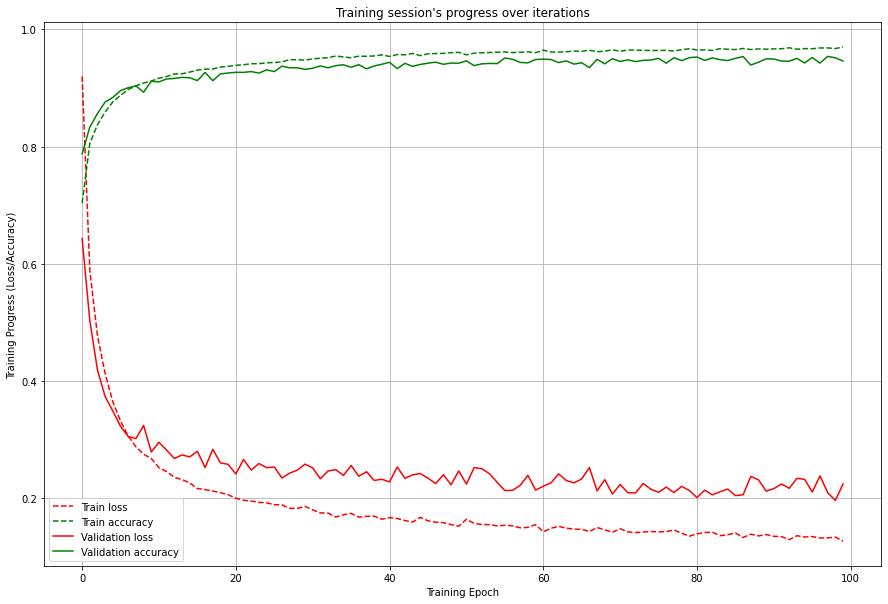

 ..after sliding and reshaping, train data: inputs (59809, 3, 100), targets (59809, 12)
 ..after sliding and reshaping, test data : inputs (890, 3, 100), targets (890, 12)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_60 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_60 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_60 (Dropout)        (None, 512)               0         
                                                                 
 dense_120 (Dense)           (None, 64)                32832     
                                                                 
 dense_121 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1623 - accuracy: 0.9574 - val_loss: 0.2222 - val_accuracy: 0.9452
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1521 - accuracy: 0.9609 - val_loss: 0.2592 - val_accuracy: 0.9333
Epoch 50/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1613 - accuracy: 0.9568 - val_loss: 0.2410 - val_accuracy: 0.9395
Epoch 51/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1554 - accuracy: 0.9603 - val_loss: 0.2260 - val_accuracy: 0.9450
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1567 - accuracy: 0.9587 - val_loss: 0.2417 - val_accuracy: 0.9355
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1517 - accuracy: 0.9604 - val_loss: 0.2351 - val_accuracy: 0.9404
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9597 - val_loss: 0.2440 - val_ac

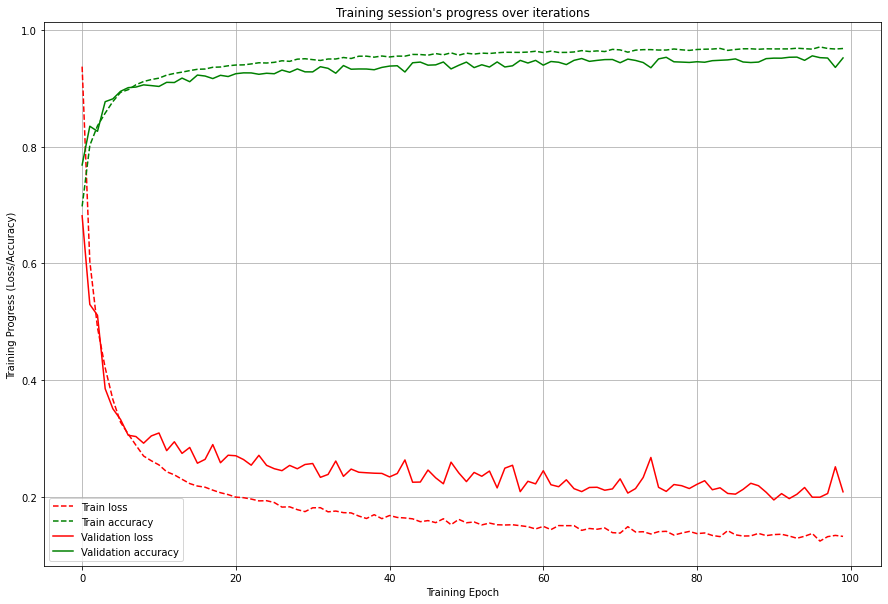

 ..after sliding and reshaping, train data: inputs (59796, 3, 100), targets (59796, 12)
 ..after sliding and reshaping, test data : inputs (902, 3, 100), targets (902, 12)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_61 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_61 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_61 (Dropout)        (None, 512)               0         
                                                                 
 dense_122 (Dense)           (None, 64)                32832     
                                                                 
 dense_123 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1568 - accuracy: 0.9603 - val_loss: 0.2136 - val_accuracy: 0.9440
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1519 - accuracy: 0.9612 - val_loss: 0.2179 - val_accuracy: 0.9462
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1514 - accuracy: 0.9605 - val_loss: 0.2437 - val_accuracy: 0.9378
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1590 - accuracy: 0.9588 - val_loss: 0.2297 - val_accuracy: 0.9369
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1617 - accuracy: 0.9590 - val_loss: 0.2176 - val_accuracy: 0.9487
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1505 - accuracy: 0.9623 - val_loss: 0.2209 - val_accuracy: 0.9449
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1567 - accuracy: 0.9598 - val_loss: 0.2210 - val_ac

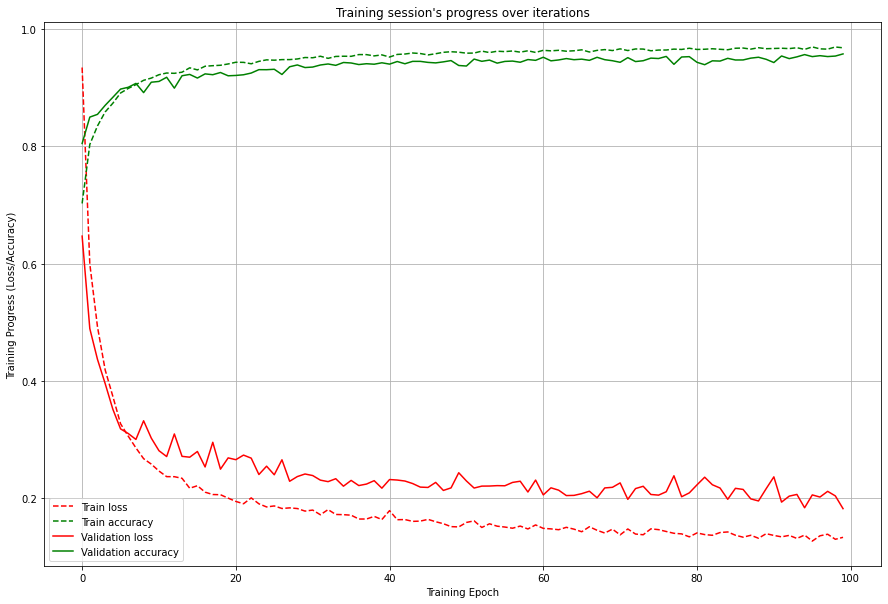

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_62 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_62 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_62 (Dropout)        (None, 512)               0         
                                                                 
 dense_124 (Dense)           (None, 64)                32832     
                                                                 
 dense_125 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1635 - accuracy: 0.9561 - val_loss: 0.3073 - val_accuracy: 0.9164
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1628 - accuracy: 0.9559 - val_loss: 0.2451 - val_accuracy: 0.9397
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1629 - accuracy: 0.9559 - val_loss: 0.2354 - val_accuracy: 0.9413
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1560 - accuracy: 0.9587 - val_loss: 0.2515 - val_accuracy: 0.9380
Epoch 52/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1575 - accuracy: 0.9577 - val_loss: 0.2474 - val_accuracy: 0.9363
Epoch 53/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1580 - accuracy: 0.9580 - val_loss: 0.2279 - val_accuracy: 0.9403
Epoch 54/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1538 - accuracy: 0.9594 - val_loss: 0.2744 - val_ac

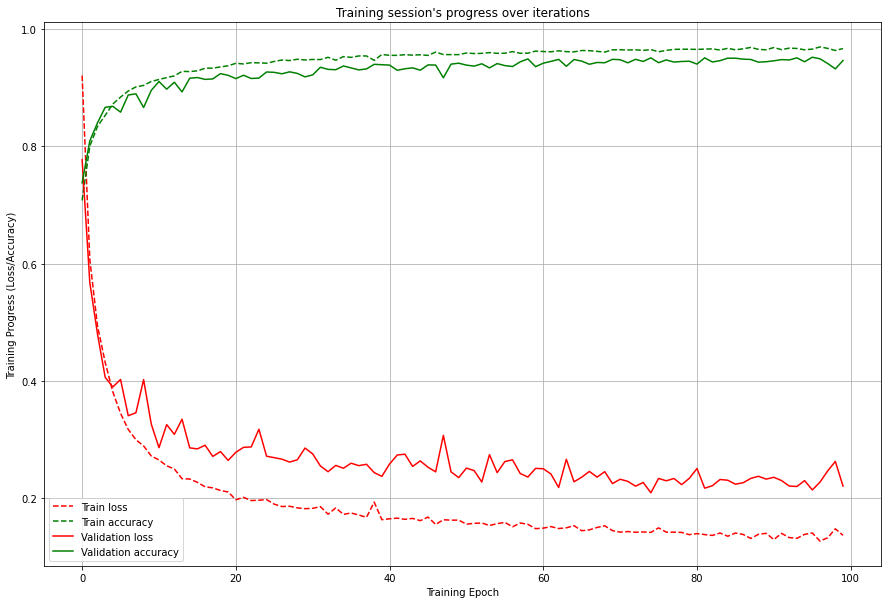

 ..after sliding and reshaping, train data: inputs (59785, 3, 100), targets (59785, 12)
 ..after sliding and reshaping, test data : inputs (913, 3, 100), targets (913, 12)
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_63 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_63 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_63 (Dropout)        (None, 512)               0         
                                                                 
 dense_126 (Dense)           (None, 64)                32832     
                                                                 
 dense_127 (D

Epoch 48/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1578 - accuracy: 0.9581 - val_loss: 0.2252 - val_accuracy: 0.9430
Epoch 49/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1537 - accuracy: 0.9593 - val_loss: 0.2338 - val_accuracy: 0.9389
Epoch 50/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1613 - accuracy: 0.9568 - val_loss: 0.2335 - val_accuracy: 0.9390
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1551 - accuracy: 0.9590 - val_loss: 0.2211 - val_accuracy: 0.9425
Epoch 52/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1540 - accuracy: 0.9600 - val_loss: 0.1957 - val_accuracy: 0.9528
Epoch 53/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1548 - accuracy: 0.9585 - val_loss: 0.2247 - val_accuracy: 0.9451
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1594 - accuracy: 0.9576 - val_loss: 0.2260 - val_ac

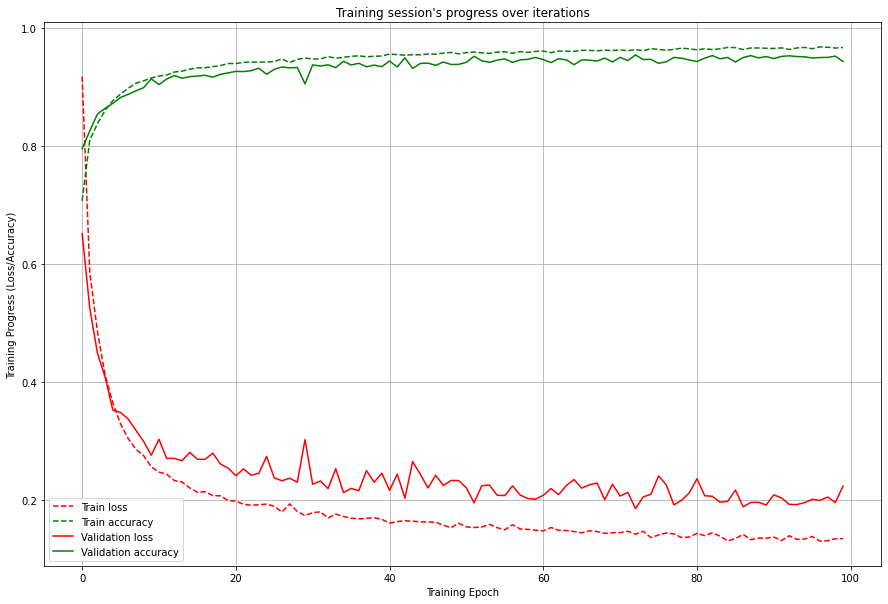

 ..after sliding and reshaping, train data: inputs (59810, 3, 100), targets (59810, 12)
 ..after sliding and reshaping, test data : inputs (889, 3, 100), targets (889, 12)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_64 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_64 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_64 (Dropout)        (None, 512)               0         
                                                                 
 dense_128 (Dense)           (None, 64)                32832     
                                                                 
 dense_129 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1571 - accuracy: 0.9589 - val_loss: 0.2307 - val_accuracy: 0.9400
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9596 - val_loss: 0.2417 - val_accuracy: 0.9380
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1575 - accuracy: 0.9592 - val_loss: 0.2359 - val_accuracy: 0.9442
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1580 - accuracy: 0.9585 - val_loss: 0.2259 - val_accuracy: 0.9442
Epoch 52/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1534 - accuracy: 0.9613 - val_loss: 0.2532 - val_accuracy: 0.9407
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1531 - accuracy: 0.9614 - val_loss: 0.2487 - val_accuracy: 0.9399
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1573 - accuracy: 0.9591 - val_loss: 0.2415 - val_ac

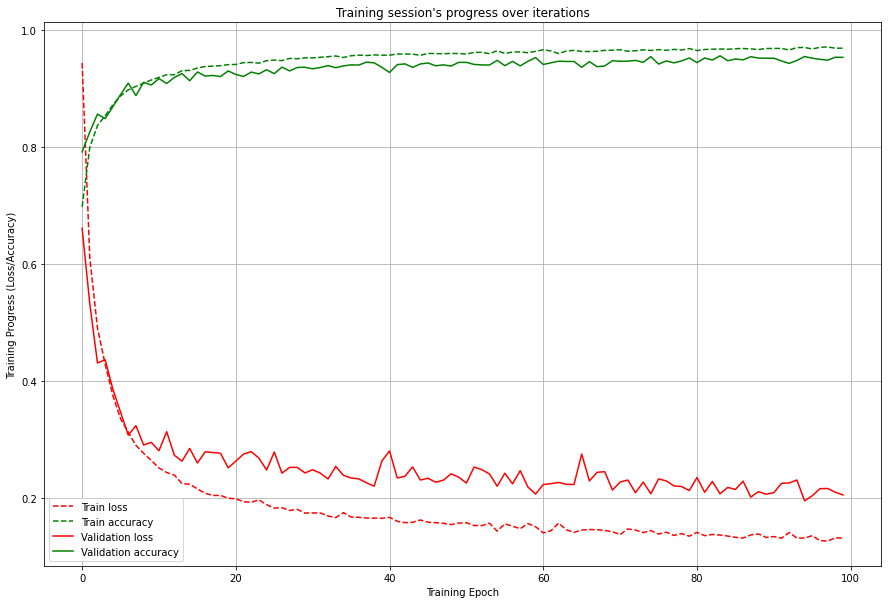

 ..after sliding and reshaping, train data: inputs (59801, 3, 100), targets (59801, 12)
 ..after sliding and reshaping, test data : inputs (898, 3, 100), targets (898, 12)
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_65 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_65 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_65 (Dropout)        (None, 512)               0         
                                                                 
 dense_130 (Dense)           (None, 64)                32832     
                                                                 
 dense_131 (D

Epoch 48/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1616 - accuracy: 0.9572 - val_loss: 0.2274 - val_accuracy: 0.9447
Epoch 49/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1537 - accuracy: 0.9599 - val_loss: 0.2300 - val_accuracy: 0.9424
Epoch 50/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1584 - accuracy: 0.9577 - val_loss: 0.2172 - val_accuracy: 0.9445
Epoch 51/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1546 - accuracy: 0.9592 - val_loss: 0.2420 - val_accuracy: 0.9391
Epoch 52/100
374/374 [==============================] - 6s 16ms/step - loss: 0.1574 - accuracy: 0.9586 - val_loss: 0.2206 - val_accuracy: 0.9437
Epoch 53/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1541 - accuracy: 0.9596 - val_loss: 0.2269 - val_accuracy: 0.9428
Epoch 54/100
374/374 [==============================] - 6s 15ms/step - loss: 0.1514 - accuracy: 0.9606 - val_loss: 0.2427 - val_ac

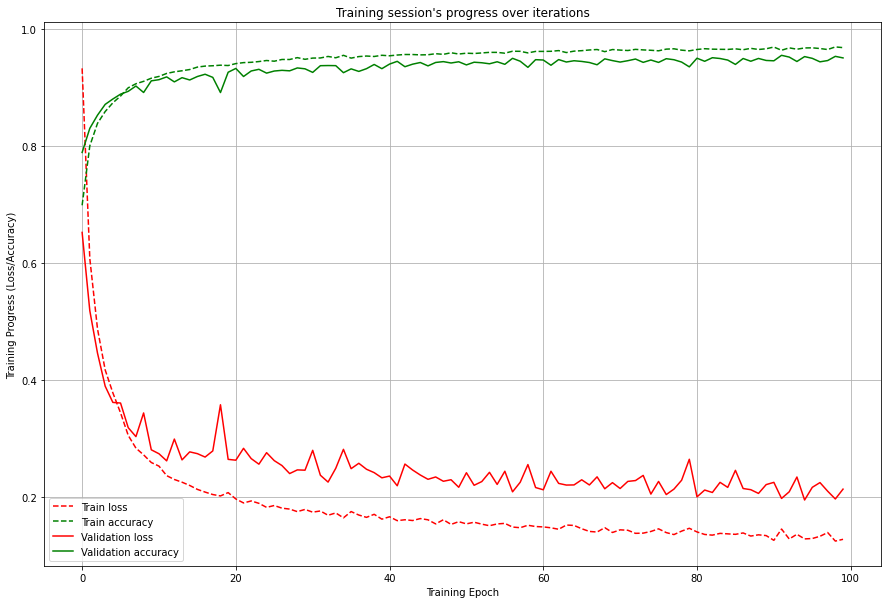

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_66 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_66 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_66 (Dropout)        (None, 512)               0         
                                                                 
 dense_132 (Dense)           (None, 64)                32832     
                                                                 
 dense_133 (D

Epoch 48/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1579 - accuracy: 0.9582 - val_loss: 0.2257 - val_accuracy: 0.9415
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1644 - accuracy: 0.9561 - val_loss: 0.2363 - val_accuracy: 0.9373
Epoch 50/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1598 - accuracy: 0.9577 - val_loss: 0.2337 - val_accuracy: 0.9395
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1578 - accuracy: 0.9586 - val_loss: 0.2208 - val_accuracy: 0.9418
Epoch 52/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1632 - accuracy: 0.9557 - val_loss: 0.2246 - val_accuracy: 0.9430
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1577 - accuracy: 0.9587 - val_loss: 0.2471 - val_accuracy: 0.9428
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1568 - accuracy: 0.9588 - val_loss: 0.2645 - val_ac

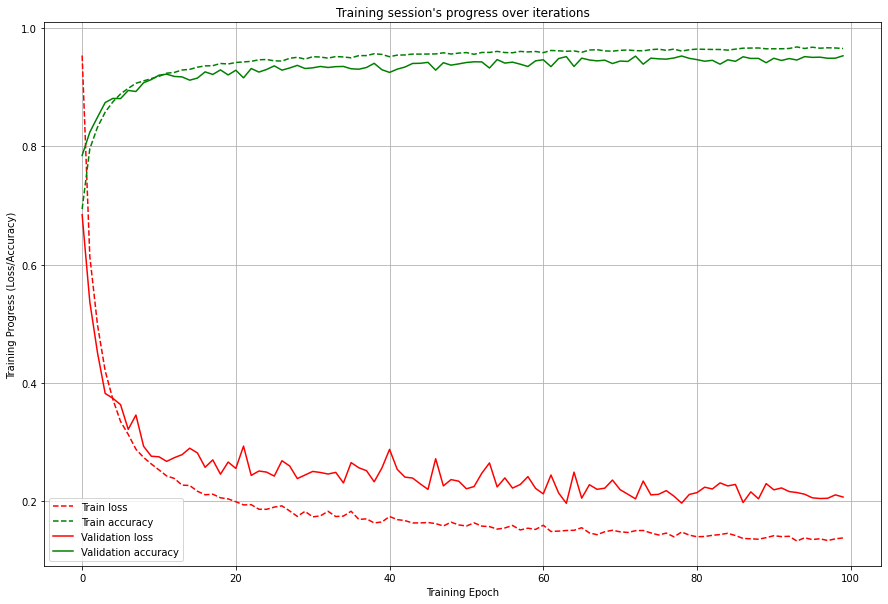

 ..after sliding and reshaping, train data: inputs (59872, 3, 100), targets (59872, 12)
 ..after sliding and reshaping, test data : inputs (826, 3, 100), targets (826, 12)
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_67 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_67 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_67 (Dropout)        (None, 512)               0         
                                                                 
 dense_134 (Dense)           (None, 64)                32832     
                                                                 
 dense_135 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1544 - accuracy: 0.9601 - val_loss: 0.2329 - val_accuracy: 0.9381
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1633 - accuracy: 0.9566 - val_loss: 0.2323 - val_accuracy: 0.9383
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1549 - accuracy: 0.9593 - val_loss: 0.2288 - val_accuracy: 0.9418
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1574 - accuracy: 0.9581 - val_loss: 0.2298 - val_accuracy: 0.9423
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1573 - accuracy: 0.9591 - val_loss: 0.2307 - val_accuracy: 0.9413
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1557 - accuracy: 0.9594 - val_loss: 0.2688 - val_accuracy: 0.9315
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1517 - accuracy: 0.9615 - val_loss: 0.2276 - val_ac

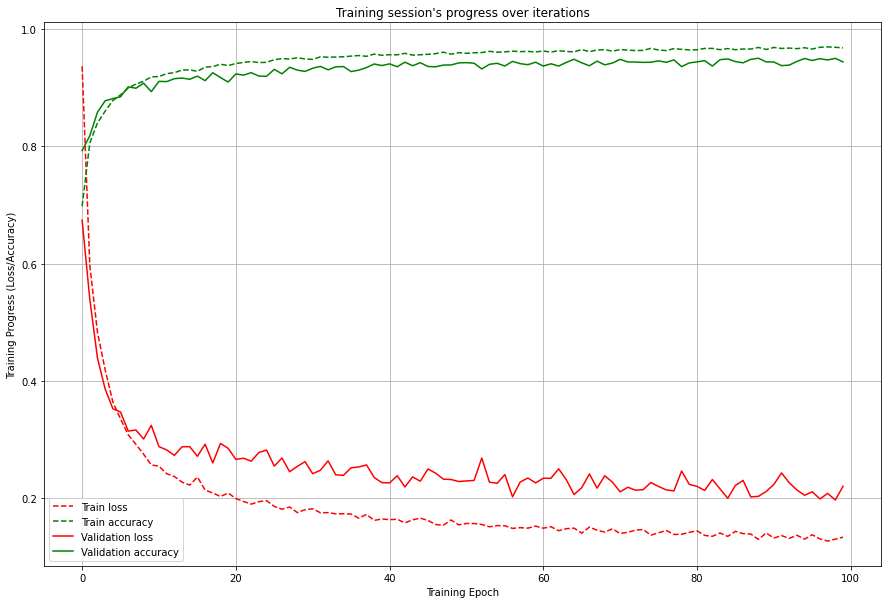

 ..after sliding and reshaping, train data: inputs (60104, 3, 100), targets (60104, 12)
 ..after sliding and reshaping, test data : inputs (595, 3, 100), targets (595, 12)
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_68 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_68 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_68 (Dropout)        (None, 512)               0         
                                                                 
 dense_136 (Dense)           (None, 64)                32832     
                                                                 
 dense_137 (D

Epoch 48/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1600 - accuracy: 0.9583 - val_loss: 0.2142 - val_accuracy: 0.9470
Epoch 49/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1563 - accuracy: 0.9592 - val_loss: 0.2425 - val_accuracy: 0.9366
Epoch 50/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9599 - val_loss: 0.2132 - val_accuracy: 0.9497
Epoch 51/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1504 - accuracy: 0.9618 - val_loss: 0.2546 - val_accuracy: 0.9357
Epoch 52/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9607 - val_loss: 0.2146 - val_accuracy: 0.9489
Epoch 53/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1520 - accuracy: 0.9605 - val_loss: 0.2385 - val_accuracy: 0.9414
Epoch 54/100
376/376 [==============================] - 6s 16ms/step - loss: 0.1565 - accuracy: 0.9594 - val_loss: 0.2113 - val_ac

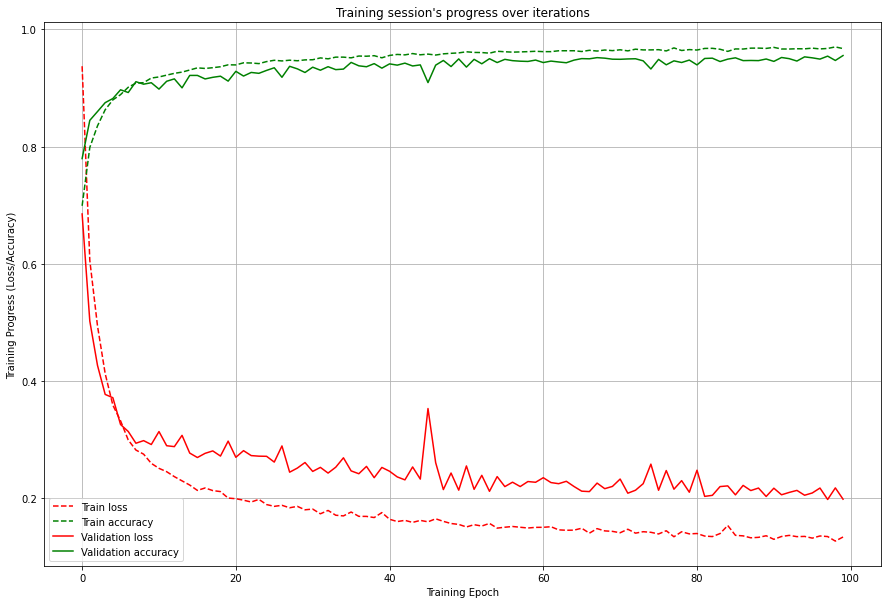

 ..after sliding and reshaping, train data: inputs (60022, 3, 100), targets (60022, 12)
 ..after sliding and reshaping, test data : inputs (677, 3, 100), targets (677, 12)
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_69 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_69 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_69 (Dropout)        (None, 512)               0         
                                                                 
 dense_138 (Dense)           (None, 64)                32832     
                                                                 
 dense_139 (D

Epoch 48/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1524 - accuracy: 0.9594 - val_loss: 0.2278 - val_accuracy: 0.9419
Epoch 49/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1580 - accuracy: 0.9578 - val_loss: 0.2413 - val_accuracy: 0.9408
Epoch 50/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1577 - accuracy: 0.9586 - val_loss: 0.2336 - val_accuracy: 0.9407
Epoch 51/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1520 - accuracy: 0.9610 - val_loss: 0.2511 - val_accuracy: 0.9322
Epoch 52/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1595 - accuracy: 0.9580 - val_loss: 0.2480 - val_accuracy: 0.9344
Epoch 53/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1492 - accuracy: 0.9627 - val_loss: 0.2616 - val_accuracy: 0.9369
Epoch 54/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1528 - accuracy: 0.9608 - val_loss: 0.2374 - val_ac

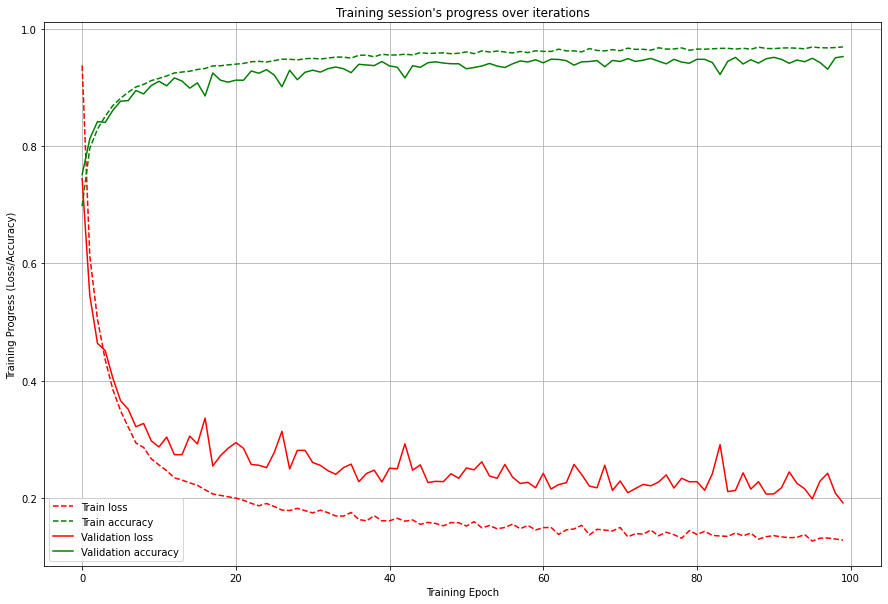

 ..after sliding and reshaping, train data: inputs (60176, 3, 100), targets (60176, 12)
 ..after sliding and reshaping, test data : inputs (522, 3, 100), targets (522, 12)
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_70 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_70 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_70 (Dropout)        (None, 512)               0         
                                                                 
 dense_140 (Dense)           (None, 64)                32832     
                                                                 
 dense_141 (D

Epoch 48/100
377/377 [==============================] - 6s 15ms/step - loss: 0.1596 - accuracy: 0.9568 - val_loss: 0.2416 - val_accuracy: 0.9373
Epoch 49/100
377/377 [==============================] - 6s 15ms/step - loss: 0.1652 - accuracy: 0.9546 - val_loss: 0.2567 - val_accuracy: 0.9339
Epoch 50/100
377/377 [==============================] - 6s 15ms/step - loss: 0.1716 - accuracy: 0.9537 - val_loss: 0.2193 - val_accuracy: 0.9440
Epoch 51/100
377/377 [==============================] - 6s 16ms/step - loss: 0.1559 - accuracy: 0.9584 - val_loss: 0.2183 - val_accuracy: 0.9401
Epoch 52/100
377/377 [==============================] - 6s 15ms/step - loss: 0.1586 - accuracy: 0.9566 - val_loss: 0.2151 - val_accuracy: 0.9468
Epoch 53/100
377/377 [==============================] - 6s 15ms/step - loss: 0.1585 - accuracy: 0.9582 - val_loss: 0.2352 - val_accuracy: 0.9394
Epoch 54/100
377/377 [==============================] - 6s 15ms/step - loss: 0.1574 - accuracy: 0.9579 - val_loss: 0.2590 - val_ac

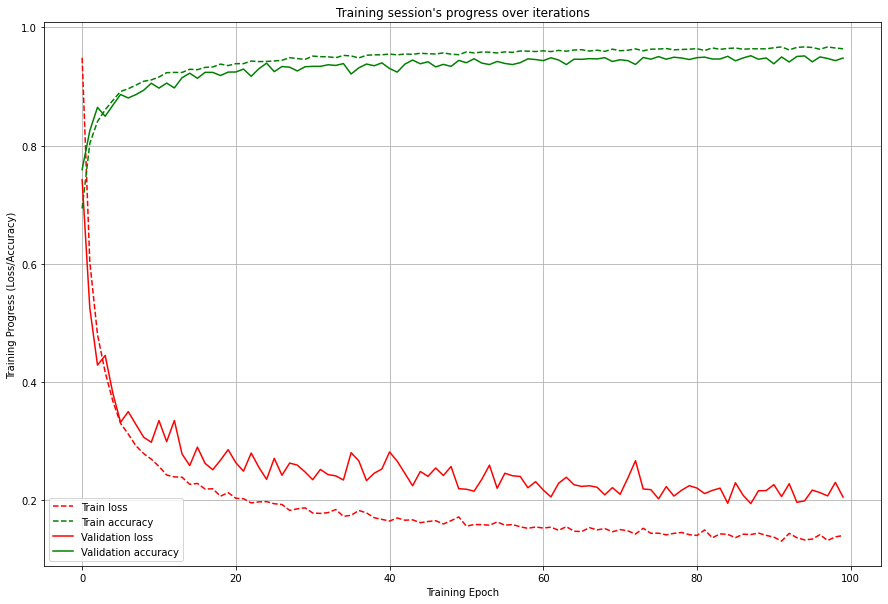

 ..after sliding and reshaping, train data: inputs (59950, 3, 100), targets (59950, 12)
 ..after sliding and reshaping, test data : inputs (749, 3, 100), targets (749, 12)
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_71 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_71 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_71 (Dropout)        (None, 512)               0         
                                                                 
 dense_142 (Dense)           (None, 64)                32832     
                                                                 
 dense_143 (D

Epoch 48/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1572 - accuracy: 0.9582 - val_loss: 0.2412 - val_accuracy: 0.9337
Epoch 49/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1547 - accuracy: 0.9592 - val_loss: 0.2717 - val_accuracy: 0.9316
Epoch 50/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1634 - accuracy: 0.9568 - val_loss: 0.2267 - val_accuracy: 0.9424
Epoch 51/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1548 - accuracy: 0.9597 - val_loss: 0.2438 - val_accuracy: 0.9395
Epoch 52/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1552 - accuracy: 0.9597 - val_loss: 0.2491 - val_accuracy: 0.9401
Epoch 53/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1543 - accuracy: 0.9597 - val_loss: 0.2285 - val_accuracy: 0.9457
Epoch 54/100
375/375 [==============================] - 6s 15ms/step - loss: 0.1558 - accuracy: 0.9599 - val_loss: 0.2323 - val_ac

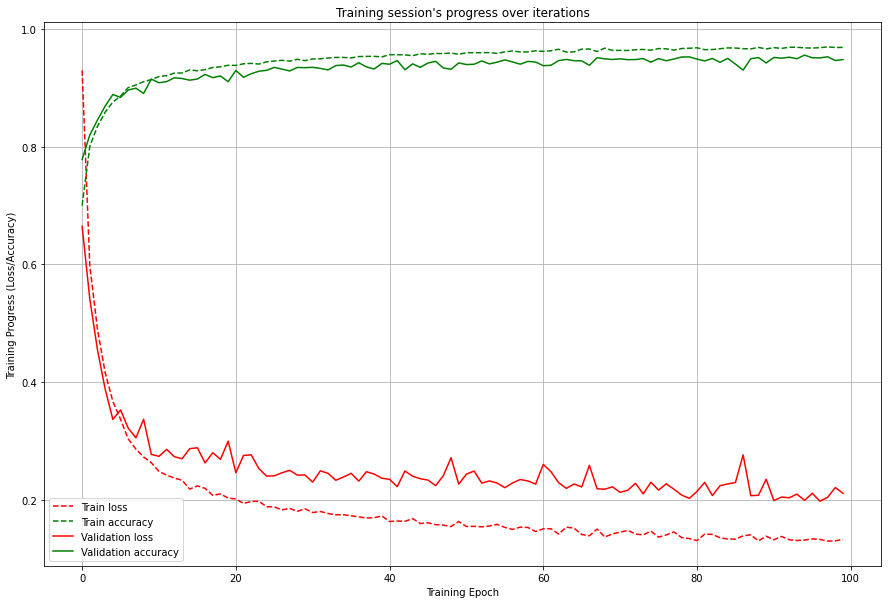

 ..after sliding and reshaping, train data: inputs (60100, 3, 100), targets (60100, 12)
 ..after sliding and reshaping, test data : inputs (598, 3, 100), targets (598, 12)
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_72 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_72 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_72 (Dropout)        (None, 512)               0         
                                                                 
 dense_144 (Dense)           (None, 64)                32832     
                                                                 
 dense_145 (D

Epoch 48/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1560 - accuracy: 0.9592 - val_loss: 0.2414 - val_accuracy: 0.9402
Epoch 49/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1621 - accuracy: 0.9565 - val_loss: 0.2253 - val_accuracy: 0.9438
Epoch 50/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1580 - accuracy: 0.9587 - val_loss: 0.2272 - val_accuracy: 0.9437
Epoch 51/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1532 - accuracy: 0.9595 - val_loss: 0.2246 - val_accuracy: 0.9469
Epoch 52/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1511 - accuracy: 0.9605 - val_loss: 0.2364 - val_accuracy: 0.9431
Epoch 53/100
376/376 [==============================] - 6s 16ms/step - loss: 0.1570 - accuracy: 0.9583 - val_loss: 0.2611 - val_accuracy: 0.9334
Epoch 54/100
376/376 [==============================] - 6s 16ms/step - loss: 0.1546 - accuracy: 0.9591 - val_loss: 0.2240 - val_ac

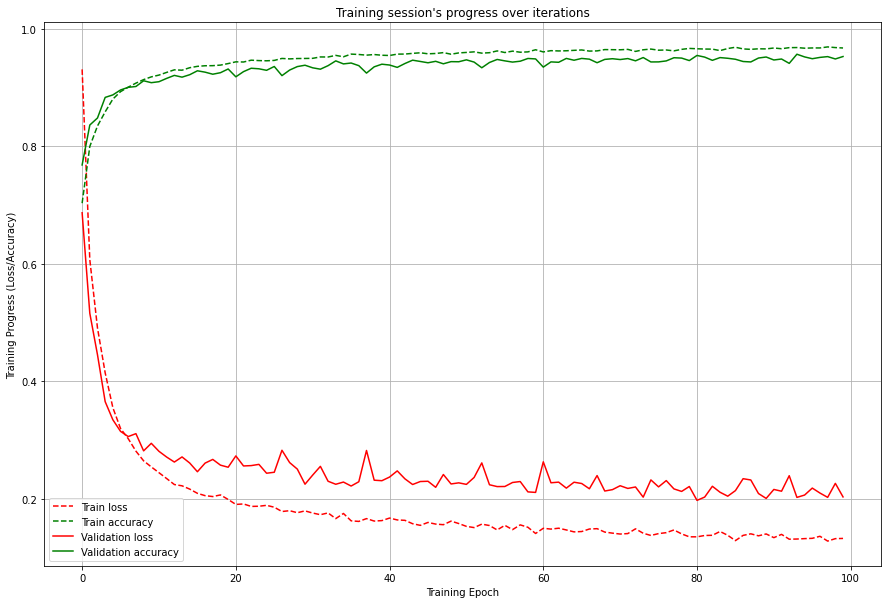

 ..after sliding and reshaping, train data: inputs (60101, 3, 100), targets (60101, 12)
 ..after sliding and reshaping, test data : inputs (598, 3, 100), targets (598, 12)
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_73 (Normaliz  (None, None, 100)         201       
 ation)                                                          
                                                                 
 bidirectional_73 (Bidirect  (None, 512)               731136    
 ional)                                                          
                                                                 
 dropout_73 (Dropout)        (None, 512)               0         
                                                                 
 dense_146 (Dense)           (None, 64)                32832     
                                                                 
 dense_147 (D

Epoch 48/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1613 - accuracy: 0.9566 - val_loss: 0.2122 - val_accuracy: 0.9499
Epoch 49/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1584 - accuracy: 0.9581 - val_loss: 0.2248 - val_accuracy: 0.9423
Epoch 50/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1562 - accuracy: 0.9595 - val_loss: 0.3465 - val_accuracy: 0.9132
Epoch 51/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1555 - accuracy: 0.9593 - val_loss: 0.2448 - val_accuracy: 0.9389
Epoch 52/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1584 - accuracy: 0.9586 - val_loss: 0.2365 - val_accuracy: 0.9427
Epoch 53/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1564 - accuracy: 0.9593 - val_loss: 0.2266 - val_accuracy: 0.9434
Epoch 54/100
376/376 [==============================] - 6s 15ms/step - loss: 0.1472 - accuracy: 0.9617 - val_loss: 0.2635 - val_ac

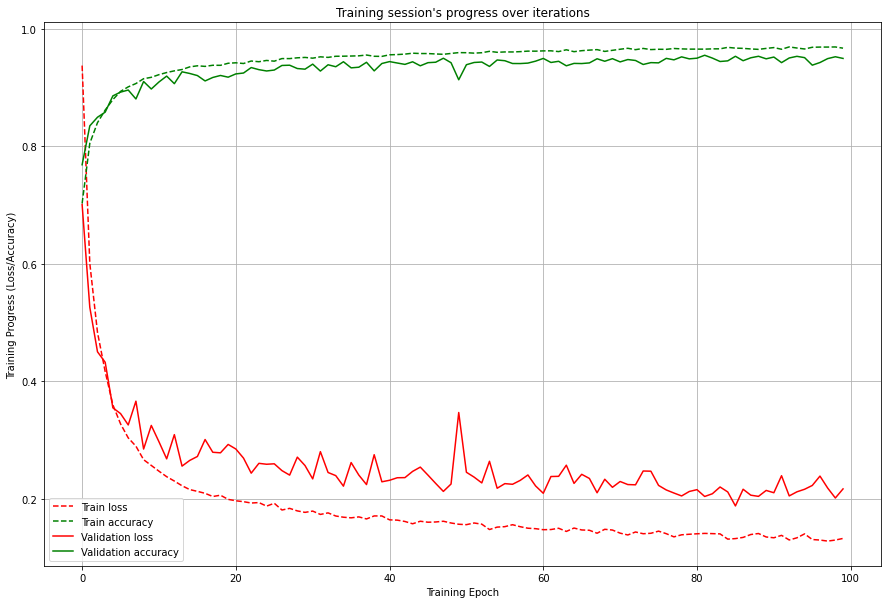

In [11]:
accuracies = []
histories = []

for i,student in enumerate(students):
# i = 53
# student = students[i]


    train_dataset = breatheNormalDataset[breatheNormalDataset.student_number != student]
    test_dataset = breatheNormalDataset[breatheNormalDataset.student_number == student]

    X_train, y_train = sliding_window(train_dataset, 'activity_label')
    X_test, y_test = sliding_window(test_dataset, 'activity_label')

    print(" ..after sliding and reshaping, train data: inputs {0}, targets {1}".format(X_train.shape, y_train.shape))
    print(" ..after sliding and reshaping, test data : inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

    model = build_model(X_train)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose=1, callbacks=[early_stopping])
    accuracy = model.evaluate(X_test, y_test, batch_size = 32, verbose=0)

    accuracies.append(accuracy[1])
    histories.append(history)

    print(f'{i}/{len(students)}', accuracy, np.average(accuracies))

    plt.figure(figsize=(15,10))
    plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
    plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
    plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
    plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
    plt.title("Training session's progress over iterations")
    plt.legend(loc='lower left')
    plt.ylabel('Training Progress (Loss/Accuracy)')
    plt.xlabel('Training Epoch')
    # plt.ylim(0)
    plt.grid()
    plt.show()

# Task 2

In [ ]:
stationary_dataset = dataset[dataset.is_stationary == 1]
stationary_dataset.head(10)

In [ ]:
stationary_dataset['activity_subactivity'] = stationary_dataset['activity'] +'_'+ stationary_dataset['sub_activity']

label_encoder = LabelEncoder()
stationary_dataset['activity_subactivity_label'] = label_encoder.fit_transform(stationary_dataset['activity_subactivity'])

len(stationary_dataset['activity_subactivity_label'].unique()), len(stationary_dataset['activity_subactivity_label'].unique())==len(stationary_dataset['activity_subactivity'].unique())


In [ ]:
def build_model_task2():
    output_dim = 7
    epochs = 100
    dropout_rate = 0.1

    input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

    # LSTM parameters
    n_neurons_lstm = 256
    n_neurons = 64

    # optimization parameters
    lr = 0.0015
    decay = 1e-6
    
    normalizer = Normalization()
    normalizer.adapt(xtrn)

    model = Sequential()
    
    model.add(normalizer)

    model.add(Bidirectional(LSTM(units = n_neurons_lstm, activation='relu',
                                 kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)), input_shape=(3,125)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)))

    model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)))

    adam = Adam(learning_rate=lr, weight_decay=decay)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    model.summary()
    
    return model

In [ ]:
accuracies = []
histories = []

for i,student in enumerate(students):
    train_dataset = stationary_dataset[stationary_dataset.student_number != student]
    test_dataset = stationary_dataset[stationary_dataset.student_number == student]
    
    X_train, y_train = sliding_window(train_dataset, 'sub_activity_label')
    X_test, y_test = sliding_window(test_dataset, 'sub_activity_label')
    
    print(" ..after sliding and reshaping, train data: inputs {0}, targets {1}".format(X_train.shape, y_train.shape))
    print(" ..after sliding and reshaping, test data : inputs {0}, targets {1}".format(X_test.shape, y_test.shape))
    
    model = build_model(X_train)
    
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose=0)
    accuracy = model.evaluate(X_test, y_test, batch_size = 32, verbose=0)
    
    accuracies.append(accuracy[1])
    histories.append(history)
    
    print(f'{i}/{len(students)}', accuracy, np.average(accuracies))
    
    plt.figure(figsize=(15,10))
    plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
    plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
    plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
    plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
    plt.title("Training session's progress over iterations")
    plt.legend(loc='lower left')
    plt.ylabel('Training Progress (Loss/Accuracy)')
    plt.xlabel('Training Epoch')
    # plt.ylim(0)
    plt.grid()
    plt.show()

# Task 3

# Task 4